In [670]:
import json
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

import seaborn as sns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)

import warnings
warnings.filterwarnings('ignore')

#df = pd.read_csv('Ladle_slag_cleaned.csv',sep=',')
ladle_countries = pd.read_csv('ladle_slags_countries.csv',sep=';',encoding='iso-8859-1')


In [809]:
df.count().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
index,Index,CaO,SiO2,Al2O3,Fe2O3,MgO,MnO,P2O5,TiO2,CaF2,f-CaO,others,FeO,S,Fe,Na2O,K2O,Cl-,SO4 2-,Mo,Zn,Ni,Cu,K,Ti,V,SO3,CO2,LOI,·others MnO + TiO2 + SO3 + Na2O + K2O,f-CaO + CaOH2,f-MgO,C,reactive SiO2,Na2Oeq,Mn2O3,ZnO,K2O + Na2O,Femet,PbO,CuO,BaO,SeO2,B2O3,FeOtotal,F,Cl,P,Sr,Ba,Pb,Sc2O3,Fe_tot,Cr,Cr2O3,Sum,Grouped column,Sample reference,Type,Main reference,Fe_Ca,Al_Si,Al_Si_kmeans
0,113,113,113,113,112,112,64,23,44,1,14,24,30,36,4,24,27,1,2,1,2,1,2,1,2,1,33,5,34,1,1,6,9,2,1,2,5,1,6,3,2,3,1,1,1,7,4,1,1,1,1,1,13,2,19,113,107,113,113,113,113,113,113


In [115]:
imputer = KNNImputer(n_neighbors=3)  # Use 3 nearest neighbors
cols = ['CaO', 'SiO2', 'Al2O3', 'Fe2O3', 'MgO', 'MnO', 'P2O5', 'TiO2',
        'S', 'Na2O', 'K2O', 'LOI','Cr2O3']

maj = df[cols]
# Perform imputation
maj_imputed = pd.DataFrame(imputer.fit_transform(maj), columns=maj.columns)
maj_imputed['b5'] = (maj_imputed['CaO']+maj_imputed['MgO'])/(maj_imputed['SiO2']+maj_imputed['Al2O3'])


In [586]:
scaler = StandardScaler()
#data_scaled = scaler.fit_transform(df[['SiO2','Al2O3']].dropna()) #'CaO','MgO',      'SiO2','Al2O3'
#data_scaled = scaler.fit_transform(maj_imputed[['CaO','Fe2O3']].dropna()) #'CaO','MgO',
data_scaled = scaler.fit_transform(maj_imputed[['Fe2O3','CaO']].dropna()) #'CaO','MgO',      'SiO2','Al2O3'

# Define ranges for eps and min_samples
eps_values = np.arange(0.2, 0.6, 0.005)  # Test eps from 0.1 to 1.0 in steps of 0.1
min_samples_values = range(2, 8)  # Test min_samples from 2 to 9

# Store results
results = []

# Loop over eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Fit DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        
        clusters = dbscan.fit_predict(data_scaled)

        # Evaluate clustering (only if more than 1 cluster is found)
        if len(set(clusters)) > 1:
            silhouette_avg = silhouette_score(data_scaled, clusters)
            db_index = davies_bouldin_score(data_scaled, clusters)
            n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # Exclude noise
            n_noise = list(clusters).count(-1)  # Count noise points
        else:
            silhouette_avg = -1  # Invalid score if only one cluster
            db_index = -1
            n_clusters = 0
            n_noise = len(clusters)

        # Store results
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette_score': silhouette_avg,
            'davies_bouldin_index': db_index,
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
#print(results_df)

# Find the best parameters based on Silhouette Score
best_result = results_df.loc[results_df['silhouette_score'].idxmax()]
print("\nBest Parameters:")
print(best_result)


Best Parameters:
eps                      0.395000
min_samples              2.000000
n_clusters               1.000000
n_noise                 11.000000
silhouette_score         0.657454
davies_bouldin_index     0.754563
Name: 234, dtype: float64


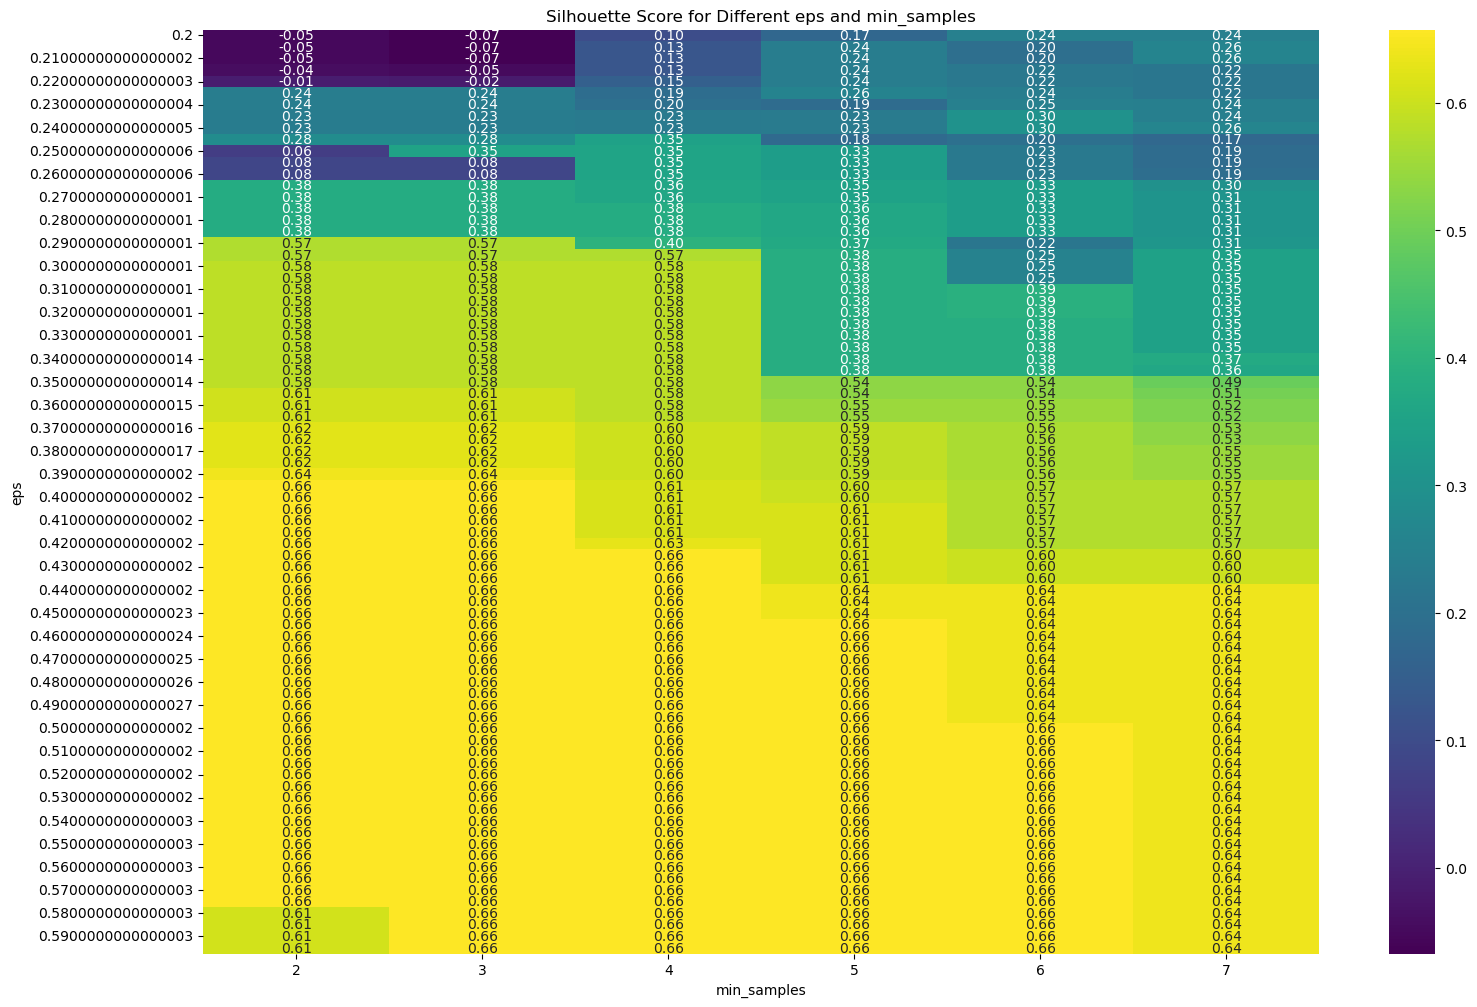

In [607]:
import seaborn as sns

# Pivot the results for a heatmap
heatmap_data = results_df.pivot(index='eps', columns='min_samples', values='silhouette_score')

# Plot the heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f")
plt.title('Silhouette Score for Different eps and min_samples')
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.show()

In [58]:
### Choose either, eps= 0.335, min samples=4 or, eps= 0.37, min samples=5 , for SiO2 and Al2O3

### Choose eps= 0.29, min samples=2, or eps=0.4, n = 2 , for CaO and Fe2O3

In [ ]:
#fe_ca = df[['Al2O3','SiO2','Al_Si_kmeans']]
#fe_ca['Si_scaled'] = data_scaled[:,0]
#fe_ca['Al_scaled'] = data_scaled[:,1]

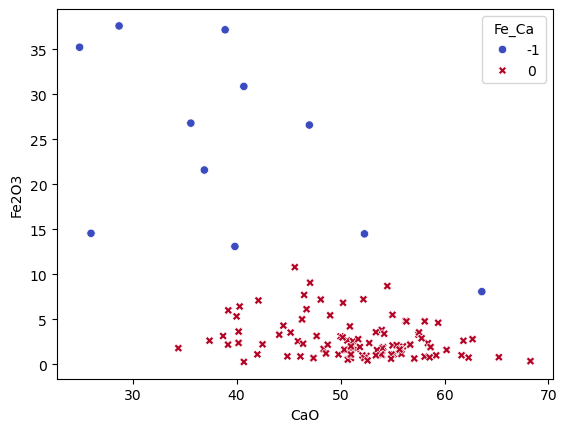

In [683]:

dbscan = DBSCAN(eps=0.40, min_samples=2)  # Adjust `eps` and `min_samples` as needed 
fe_ca_clusters= dbscan.fit_predict(data_scaled)
df['Fe_Ca'] = fe_ca_clusters
maj_imputed['Fe_Ca'] = fe_ca_clusters
#plt.scatter(data_scaled[:, 1], data_scaled[:, 0], c=df['Fe_Ca'], cmap='viridis', marker='o')
sns.scatterplot(data=maj_imputed, x='CaO', y='Fe2O3', palette='coolwarm', hue='Fe_Ca',style='Fe_Ca')
plt.xlabel('CaO')
plt.ylabel('Fe2O3')
#plt.title(f"CaO_Fe2O3 system: Silhouette score: 0.65")
plt.savefig('../Figures/Ca_Fe_system',bbox_inches='tight')#,pad_inches=0.1
#plt.colorbar(label='Cluster')
plt.show()


#plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=df['Al_Si_kmeans'], cmap='viridis', marker='o')
#plt.scatter(, c=df['Al_Si_kmeans'], cmap='viridis', marker='o')
#sns.scatterplot(data=al_si, x='Si_scaled', y='Al_scaled', hue='Al_Si_kmeans',style='Al_Si_kmeans')
#plt.xlabel('SiO2')
#plt.ylabel('Al2O3')
#plt.title(f'Al_Si system, Silhouette score: {Al_si_silhouette.round(2)}')
#plt.colorbar(label='Cluster')
#plt.legend()
#plt.savefig('../Figures/Al_Si_kmeans')
#plt.show()

In [120]:
df['Fe_Ca'].value_counts()


Fe_Ca
 0    102
-1     11
Name: count, dtype: int64

### FeO content

In [611]:
#df[df['Fe_Ca']==0].describe()[['CaO','SiO2','Al2O3','Fe2O3','MgO','MnO','P2O5','TiO2','f-CaO','others','FeO','S','Na2O','K2O','SO3','LOI','Fe_tot','Cr2O3']].round(2)
df[df['Fe_Ca']==0].describe()[['CaO','SiO2','Al2O3','Fe2O3','MgO','MnO']].round(2)

,CaO,SiO2,Al2O3,Fe2O3,MgO,MnO
count,102.00,102.00,102.00,101.00,101.00,62.00
mean,51.14,17.82,12.75,2.82,8.36,0.80
std,6.63,8.37,9.47,2.15,4.19,0.80
min,34.40,0.73,1.15,0.27,2.13,0.05
25%,46.56,11.72,4.84,1.10,5.40,0.28
50%,51.60,17.70,10.21,2.19,7.10,0.52
75%,55.70,22.88,19.58,3.64,11.00,0.93
max,68.27,50.10,36.91,10.80,21.50,4.00


In [609]:
#df[df['Fe_Ca']==-1].describe()[['CaO','SiO2','Al2O3','Fe2O3','MgO','MnO','P2O5','TiO2','f-CaO','others','FeO','S','Na2O','K2O','SO3','LOI','Fe_tot','Cr2O3']].round(2)
df[df['Fe_Ca']==-1].describe()[['CaO','SiO2','Al2O3','Fe2O3','MgO','MnO']].round(2)



,CaO,SiO2,Al2O3,Fe2O3,MgO,MnO
count,11.00,11.00,11.00,11.00,11.00,2.00
mean,39.49,16.67,8.96,24.19,8.12,1.50
std,11.56,6.25,12.30,10.50,2.85,0.54
min,24.90,6.80,0.00,8.08,2.60,1.12
25%,32.15,13.75,2.79,14.53,6.18,1.31
50%,38.90,16.50,4.13,26.59,8.63,1.50
75%,43.85,20.00,5.75,33.06,10.60,1.70
max,63.59,27.80,36.30,37.60,11.40,1.89


In [569]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[['SiO2','Al2O3']].dropna()) #'CaO','MgO',      'SiO2','Al2O3'
#data_scaled = scaler.fit_transform(maj_imputed[['CaO','Fe2O3']].dropna()) #'CaO','MgO',
#data_scaled = scaler.fit_transform(maj_imputed[['SiO2','Al2O3']].dropna()) #'CaO','MgO',      'SiO2','Al2O3'


num_clusters = 2  # Choose the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_clusters = kmeans.fit_predict(data_scaled)
df['Al_Si_kmeans'] = kmeans_clusters
maj_imputed['Al_Si_kmeans'] = kmeans_clusters
Al_si_silhouette = silhouette_score(data_scaled, kmeans_clusters)



# Define ranges for eps and min_samples
eps_values = np.arange(0.2, 0.6, 0.005)  # Test eps from 0.1 to 1.0 in steps of 0.1
min_samples_values = range(2, 8)  # Test min_samples from 2 to 9

# Store results
results = []

# Loop over eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Fit DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(data_scaled)

        # Evaluate clustering (only if more than 1 cluster is found)
        if len(set(clusters)) > 1:
            silhouette_avg = silhouette_score(data_scaled, clusters)
            db_index = davies_bouldin_score(data_scaled, clusters)
            n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # Exclude noise
            n_noise = list(clusters).count(-1)  # Count noise points
        else:
            silhouette_avg = -1  # Invalid score if only one cluster
            db_index = -1
            n_clusters = 0
            n_noise = len(clusters)

        # Store results
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette_score': silhouette_avg,
            'davies_bouldin_index': db_index,
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
#print(results_df)

# Find the best parameters based on Silhouette Score
best_result = results_df.loc[results_df['silhouette_score'].idxmax()]
print("\nBest Parameters:")
print(best_result)


Best Parameters:
eps                     0.455000
min_samples             2.000000
n_clusters              1.000000
n_noise                 4.000000
silhouette_score        0.504852
davies_bouldin_index    1.916155
Name: 306, dtype: float64


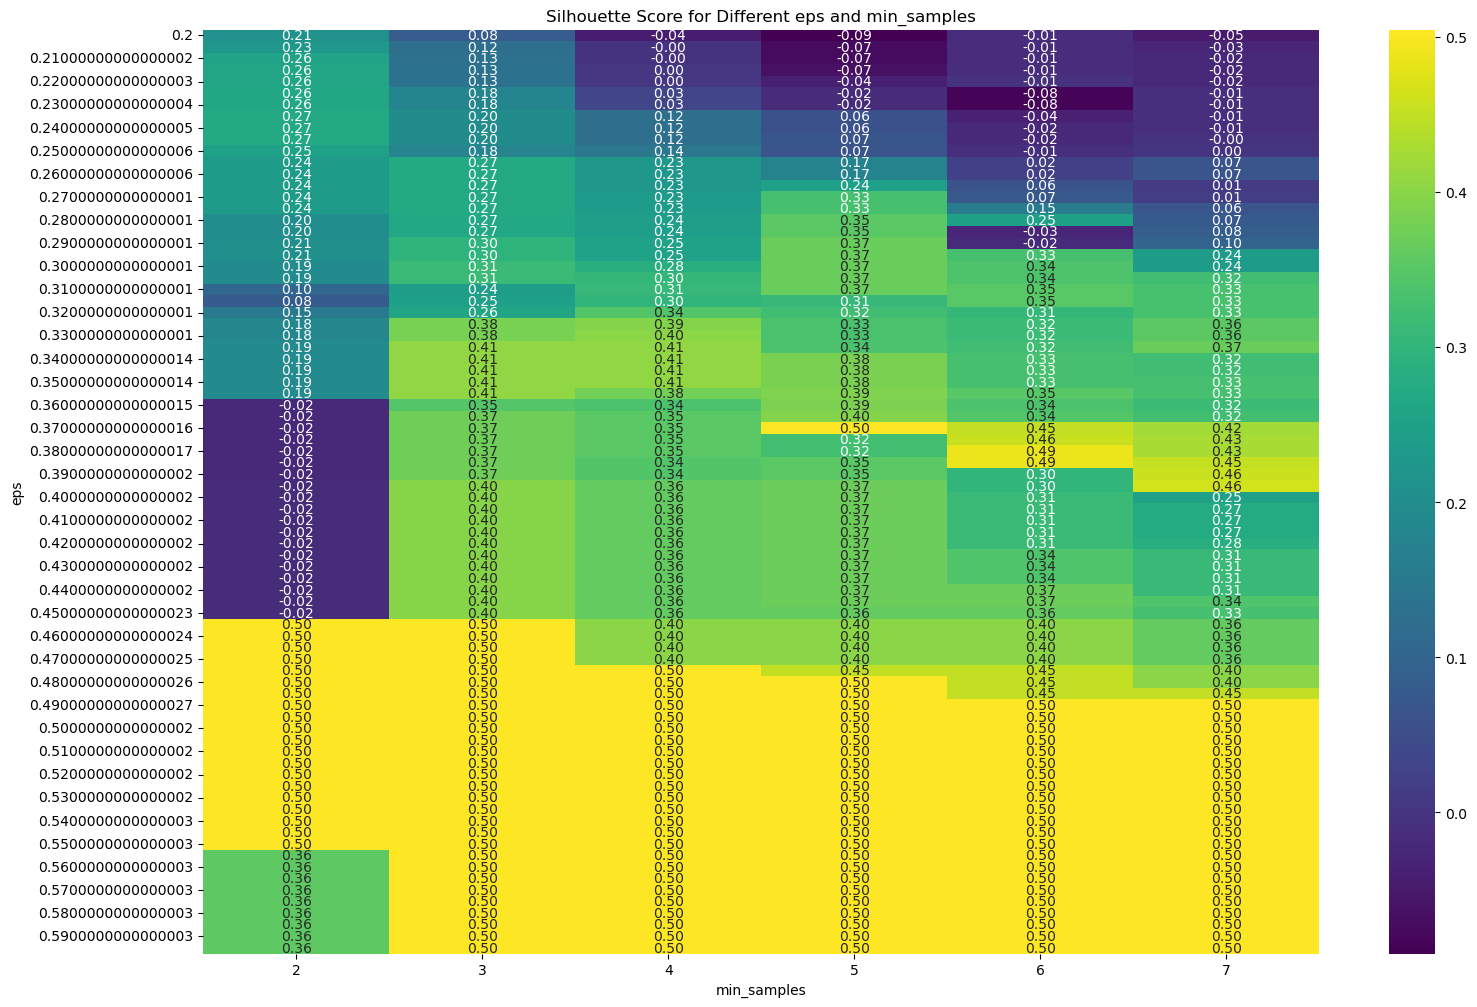

In [268]:
import seaborn as sns

# Pivot the results for a heatmap
heatmap_data = results_df.pivot(index='eps', columns='min_samples', values='silhouette_score')

# Plot the heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f")
plt.title('Silhouette Score for Different eps and min_samples')
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.show()

In [581]:


#dbscan = DBSCAN(eps=0.3698, min_samples=5)  # Adjust `eps` and `min_samples` as needed 
#al_si_clusters= dbscan.fit_predict(data_scaled)
#df['Al_Si'] = al_si_clusters
#maj_imputed['Al_Si'] = al_si_clusters 
#plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=df['Al_Si'], cmap='viridis', marker='o')
#plt.xlabel('SiO2')
#plt.ylabel('Al2O3')
#plt.title(f'DBSCAN Clustering: eps={0.40}')
#plt.colorbar(label='Cluster')
#plt.show()

In [565]:
al_si = df[['Al2O3','SiO2','Al_Si_kmeans']]
al_si['Si_scaled'] = data_scaled[:,0]
al_si['Al_scaled'] = data_scaled[:,1]

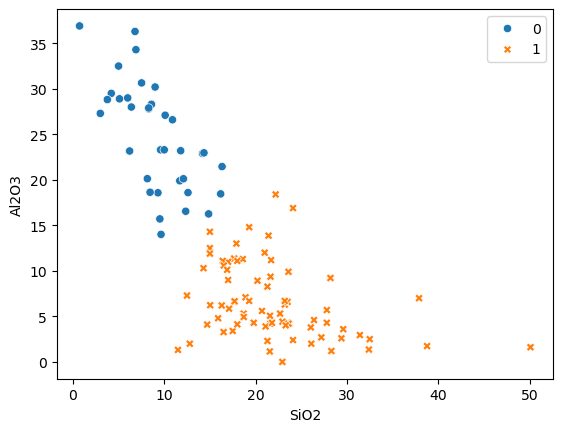

In [682]:
#plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=df['Al_Si_kmeans'], cmap='viridis', marker='o')
#plt.scatter(, c=df['Al_Si_kmeans'], cmap='viridis', marker='o')
sns.scatterplot(data=al_si, x='SiO2', y='Al2O3', hue='Al_Si_kmeans',style='Al_Si_kmeans')
plt.xlabel('SiO2')
plt.ylabel('Al2O3')
#plt.title(f'SiO2-Al2O3 system, Silhouette score: {Al_si_silhouette.round(2)}')
#plt.colorbar(label='Cluster')
plt.legend()
plt.savefig('../Figures/Al_Si_kmeans',bbox_inches='tight')
plt.show()

In [270]:
df['Al_Si_kmeans'].value_counts()


Al_Si_kmeans
1    77
0    36
Name: count, dtype: int64

In [661]:
#df[df['Al_Si_kmeans']==0].describe()[['CaO','SiO2','Al2O3','Fe2O3','MgO','MnO','P2O5','TiO2','f-CaO','others','FeO','S','Na2O','K2O','SO3','LOI','Fe_tot','Cr2O3']].round(2)
df[df['Al_Si_kmeans']==0].describe()[['CaO','SiO2','Al2O3','Fe2O3','MgO']].round(2)

,CaO,SiO2,Al2O3,Fe2O3,MgO
count,36.00,36.00,36.00,36.00,36.00
mean,50.94,9.07,24.88,3.53,7.03
std,7.35,3.68,5.91,3.27,2.84
min,26.00,0.73,14.01,0.53,2.90
25%,48.43,6.70,20.07,1.08,5.00
50%,50.95,8.80,24.95,2.95,6.38
75%,55.96,11.72,28.84,5.00,8.70
max,65.23,16.33,36.91,14.56,13.60


In [662]:
#df[df['Al_Si_kmeans']==1].describe()[['CaO','SiO2','Al2O3','Fe2O3','MgO','MnO','P2O5','TiO2','f-CaO','others','FeO','S','Na2O','K2O','SO3','LOI','Fe_tot','Cr2O3']].round(2)
df[df['Al_Si_kmeans']==1].describe()[['CaO','SiO2','Al2O3','Fe2O3','MgO']].round(2)

,CaO,SiO2,Al2O3,Fe2O3,MgO
count,77.00,77.00,77.00,76.00,76.00
mean,49.57,21.74,6.53,5.58,8.95
std,8.26,6.35,4.04,8.66,4.43
min,24.90,11.50,0.00,0.27,2.13
25%,44.89,17.65,3.90,1.62,5.80
50%,51.00,21.30,5.31,2.37,8.25
75%,55.00,23.60,9.36,3.88,11.90
max,68.27,50.10,18.40,37.60,21.50


In [1012]:
#maj_imputed
fe_ca_stats = maj_imputed.groupby('Fe_Ca')[['Fe2O3','CaO']].agg(['mean', 'std'])
al_si_stats = maj_imputed.groupby('Al_Si_kmeans')[['Al2O3', 'SiO2','MgO']].agg(['mean', 'std'])

In [1013]:
fe_ca_stats.columns = ['Fe2O3_mean', 'Fe2O3_std', 'CaO_mean', 'CaO_std']
fe_ca_stats = fe_ca_stats.reset_index()

al_si_stats.columns = ['Al2O3_mean', 'Al2O3_std', 'SiO2_mean', 'SiO2_std','MgO_mean', 'MgO_std']
al_si_stats = al_si_stats.reset_index()

In [1015]:
test = pd.merge(maj_imputed,fe_ca_stats, how='inner',on='Fe_Ca')
test = pd.merge(test,al_si_stats, how='inner',on='Al_Si_kmeans')

In [1016]:
test.head()

,CaO,SiO2,Al2O3,Fe2O3,MgO,MnO,P2O5,TiO2,S,Na2O,K2O,LOI,Cr2O3,b5,Fe_Ca,Al_Si,Al_Si_kmeans,Fe2O3_mean,Fe2O3_std,CaO_mean,CaO_std,Al2O3_mean,Al2O3_std,SiO2_mean,SiO2_std,MgO_mean,MgO_std
0,40.70,22.20,18.40,0.27,14.50,0.400000,0.100000,0.23,1.100000,0.190000,0.126667,9.686667,0.333333,1.359606,0,-1,1,2.811170,2.141654,51.142843,6.629331,6.533766,4.043872,21.741351,6.349724,8.896013,4.424043
1,52.49,28.20,9.22,0.93,5.46,1.186667,0.030000,0.77,0.548333,0.876667,0.060000,6.443333,0.033333,1.548637,0,1,1,2.811170,2.141654,51.142843,6.629331,6.533766,4.043872,21.741351,6.349724,8.896013,4.424043
2,39.84,7.52,30.65,13.10,5.54,1.110000,0.266667,0.41,0.243333,0.336667,0.070667,0.533333,0.400000,1.188892,-1,0,0,24.191182,10.504750,39.493545,11.560201,24.878889,5.911972,9.071667,3.681208,7.026111,2.839892
3,26.00,6.80,36.30,14.56,9.10,0.866667,0.253667,0.41,0.010000,0.079333,0.070667,0.533333,0.130000,0.814385,-1,-1,0,24.191182,10.504750,39.493545,11.560201,24.878889,5.911972,9.071667,3.681208,7.026111,2.839892
4,39.20,6.90,34.30,6.00,9.20,1.433333,0.266667,0.40,0.020000,0.336667,0.040667,0.533333,0.400000,1.174757,0,0,0,2.811170,2.141654,51.142843,6.629331,24.878889,5.911972,9.071667,3.681208,7.026111,2.839892


In [847]:
maj_imputed[['CaO','SiO2','Al2O3','Fe2O3','MgO']].describe()

,CaO,SiO2,Al2O3,Fe2O3,MgO
count,113.000000,113.000000,113.000000,113.000000,113.000000
mean,50.008841,17.704991,12.378230,4.892410,8.300292
std,7.974618,8.170216,9.784217,7.383283,4.070289
min,24.899000,0.730000,0.000000,0.270000,2.130000
25%,45.900000,11.800000,4.300000,1.160000,5.400000
50%,51.000000,17.700000,9.220000,2.370000,7.300000
75%,55.400000,22.680000,18.640000,4.780000,10.900000
max,68.270000,50.100000,36.910000,37.600000,21.500000


In [279]:
fe_ca_stats

,Fe_Ca,Fe2O3_mean,Fe2O3_std,CaO_mean,CaO_std
0,-1,24.191182,10.504750,39.493545,11.560201
1,0,2.811170,2.141654,51.142843,6.629331


In [281]:
al_si_stats

,Al_Si_kmeans,Al2O3_mean,Al2O3_std,SiO2_mean,SiO2_std
0,0,24.878889,5.911972,9.071667,3.681208
1,1,6.533766,4.043872,21.741351,6.349724


In [875]:
al_si_stats[al_si_stats['Al_Si_kmeans']==1]['SiO2_std']

1    6.349724
Name: SiO2_std, dtype: float64

In [895]:
cluster_data = {'Parameters':['Al2O3','SiO2','CaO','Fe2O3'],
                'Full dataset mean': [maj_imputed['Al2O3'].mean(),maj_imputed['SiO2'].mean(),maj_imputed['CaO'].mean(),maj_imputed['Fe2O3'].mean()],
                'Full dataset std': [maj_imputed['Al2O3'].std(),maj_imputed['SiO2'].std(),maj_imputed['CaO'].std(),maj_imputed['Fe2O3'].std()],
                'High Al, Low Si mean': [al_si_stats[al_si_stats['Al_Si_kmeans']==0]['Al2O3_mean'][0],al_si_stats[al_si_stats['Al_Si_kmeans']==0]['SiO2_mean'][0],np.nan,np.nan],
                'High Al, Low Si std': [al_si_stats[al_si_stats['Al_Si_kmeans']==0]['Al2O3_std'][0],al_si_stats[al_si_stats['Al_Si_kmeans']==0]['SiO2_std'][0],np.nan,np.nan],
                
                'High Si, Low Al mean': [al_si_stats[al_si_stats['Al_Si_kmeans']==1]['Al2O3_mean'][1],al_si_stats[al_si_stats['Al_Si_kmeans']==1]['SiO2_mean'][1],np.nan,np.nan],
                'High Si, Low Al std': [al_si_stats[al_si_stats['Al_Si_kmeans']==1]['Al2O3_std'][1],al_si_stats[al_si_stats['Al_Si_kmeans']==1]['SiO2_std'][1],np.nan,np.nan],
                
                'High Ca, Low Fe mean': [np.nan,np.nan,fe_ca_stats[fe_ca_stats['Fe_Ca']==0]['CaO_mean'][1],fe_ca_stats[fe_ca_stats['Fe_Ca']==0]['Fe2O3_mean'][1]],
                'High Ca, Low Fe std': [np.nan,np.nan,fe_ca_stats[fe_ca_stats['Fe_Ca']==0]['CaO_std'][1],fe_ca_stats[fe_ca_stats['Fe_Ca']==0]['Fe2O3_std'][1]],
                
                'High Fe, Low Ca mean': [np.nan,np.nan,fe_ca_stats[fe_ca_stats['Fe_Ca']==-1]['CaO_mean'][0],fe_ca_stats[fe_ca_stats['Fe_Ca']==-1]['Fe2O3_mean'][0]],
                'High Fe, Low Ca std': [np.nan,np.nan,fe_ca_stats[fe_ca_stats['Fe_Ca']==-1]['CaO_std'][0],fe_ca_stats[fe_ca_stats['Fe_Ca']==-1]['Fe2O3_std'][0]],
               }
cluster_stats = pd.DataFrame(data=cluster_data)
cluster_stats = cluster_stats.round(2)

In [898]:
cluster_stats.to_csv('../cluster_stats.csv',sep=',',index=False)
cluster_stats

,Parameters,Full dataset mean,Full dataset std,"High Al, Low Si mean","High Al, Low Si std","High Si, Low Al mean","High Si, Low Al std","High Ca, Low Fe mean","High Ca, Low Fe std","High Fe, Low Ca mean","High Fe, Low Ca std"
0,Al2O3,12.38,9.78,24.88,5.91,6.53,4.04,NaN,NaN,NaN,NaN
1,SiO2,17.70,8.17,9.07,3.68,21.74,6.35,NaN,NaN,NaN,NaN
2,CaO,50.01,7.97,NaN,NaN,NaN,NaN,51.14,6.63,39.49,11.56
3,Fe2O3,4.89,7.38,NaN,NaN,NaN,NaN,2.81,2.14,24.19,10.50


In [942]:
cluster_stats[['Full dataset std','High Al, Low Si std','High Si, Low Al std','High Ca, Low Fe std','High Fe, Low Ca std']]

,Full dataset std,"High Al, Low Si std","High Si, Low Al std","High Ca, Low Fe std","High Fe, Low Ca std"
0,9.78,5.91,4.04,NaN,NaN
1,8.17,3.68,6.35,NaN,NaN
2,7.97,NaN,NaN,6.63,11.56
3,7.38,NaN,NaN,2.14,10.50


In [954]:
al_si_std

{'Full dataset std.dev': 0    9.78
 1    8.17
 2    7.97
 3    7.38
 Name: Full dataset std, dtype: float64,
 'High Al, Low Si': 0    5.91
 1    3.68
 2     NaN
 3     NaN
 Name: High Al, Low Si std, dtype: float64,
 'High Si, Low Al': 0    4.04
 1    6.35
 2     NaN
 3     NaN
 Name: High Si, Low Al std, dtype: float64}

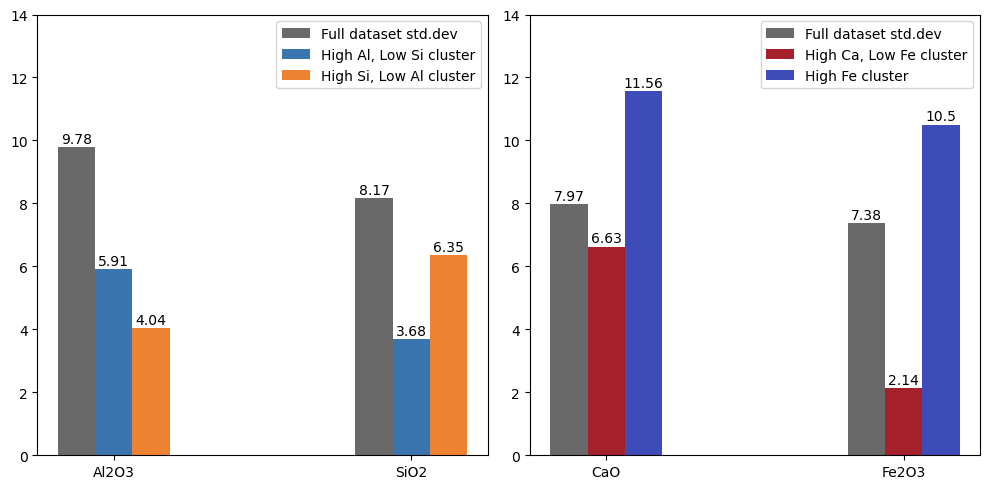

In [2483]:


al_si_std = {
    'Full dataset std.dev': cluster_stats['Full dataset std'][0:2],
    'High Al, Low Si cluster': cluster_stats['High Al, Low Si std'][0:2],
    'High Si, Low Al cluster': cluster_stats['High Si, Low Al std'][0:2],
    
}

fe_ca_std = {
    'Full dataset std.dev': cluster_stats['Full dataset std'][2:],
    'High Ca, Low Fe cluster': cluster_stats['High Ca, Low Fe std'][2:],
    'High Fe cluster': cluster_stats['High Fe, Low Ca std'][2:]
}

# Define parameters (3 bars per group)
grouped_bar_params = ['Al2O3','SiO2','CaO','Fe2O3']  # Must match the number of bars (3)
custom_colors = ['#6A6969','#3B75AF', '#EE8233', '#A4212B','#3E4CB9']  # Gray, Al, Si, Ca, Fe
width = 0.1


# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot Group 1
multiplier = 0
for (group, values), color in zip(al_si_std.items(), custom_colors[0:3]):
    offset = width * multiplier
    bars = ax1.bar(np.arange(len(grouped_bar_params[0:2]))*0.8 + offset, values, width,label=group, color=color)
    ax1.bar_label(bars, padding=1, fontsize=10)
    multiplier += 1
ax1.set_xticks(np.arange(len(grouped_bar_params[0:2]))*0.8 + width, grouped_bar_params[0:2],fontsize=10)
#ax1.set_title('Al2O3 - SiO2 clusters')
ax1.legend()
ax1.set_ylim(0,14)

x



# Plot Group 2
multiplier = 0
for (group, values), color in zip(fe_ca_std.items(), custom_colors[2:]): 
    if group == 'Full dataset std.dev': # Had to do awkward logic to get the gray color from idx 0, to the second figure.
        color = '#6A6969'
    offset = width * multiplier
    bars = ax2.bar(np.arange(len(grouped_bar_params[2:]))*0.8 + offset, values, width, label=group, color=color)
    ax2.bar_label(bars, padding=1, fontsize=10)
    multiplier += 1
ax2.set_xticks(np.arange(len(grouped_bar_params[2:]))*0.8 + width, grouped_bar_params[2:],fontsize=10)
#ax2.set_title('CaO - Fe2O3 clusters')
ax2.legend()
ax2.set_ylim(0,14)

plt.tight_layout()
plt.savefig('../Figures/cluster_std_comparison_to_full_dataset.png', bbox_inches='tight',pad_inches = 0.1)
plt.show()

In [2524]:
corrmat = test[['b5','CaO','SiO2','Al2O3','Fe2O3','MgO']].corr().round(2)
b5_corr = corrmat['b5'].reset_index().T
columns = b5_corr.iloc[0,:]
b5_corr = b5_corr.drop(index='index')#iloc[1,:].reset_index().T
b5_corr.columns = columns
b5_corr.iloc[:,1:].to_csv('../Tables/b5_corr.csv')


corrmat = test[['b_CaSiAl','CaO','SiO2','Al2O3','Fe2O3','MgO']].corr().round(2)
b_CaSiAl_corr = corrmat['b_CaSiAl'].reset_index().T
columns = b_CaSiAl_corr.iloc[0,:]
b_CaSiAl_corr = b_CaSiAl_corr.drop(index='index')#iloc[1,:].reset_index().T
b_CaSiAl_corr.columns = columns
b_CaSiAl_corr.iloc[:,1:].to_csv('../Tables/b_CaSiAl_corr.csv')

In [2525]:
b5_corr.iloc[:,1:]

index,CaO,SiO2,Al2O3,Fe2O3,MgO
b5,0.43,-0.12,-0.46,0.03,0.22


In [2526]:
b_CaSiAl_corr.iloc[:,1:]

index,CaO,SiO2,Al2O3,Fe2O3,MgO
b_CaSiAl,0.61,-0.11,-0.43,-0.03,-0.06


In [2829]:
b3 = b_CaSiAl_corr.iloc[:,1:]
b3.index = ['b3']

In [2830]:
b3

index,CaO,SiO2,Al2O3,Fe2O3,MgO
b3,0.61,-0.11,-0.43,-0.03,-0.06


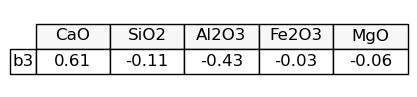

In [2831]:
# Create figure
fig, ax = plt.subplots(figsize=(4, 1))  # Adjust size as needed
ax.axis('off')  # Hide axes

# Create table
table = plt.table(
    cellText=b3.values,
    colLabels=b3.columns,
    rowLabels=b3.index,
    loc='center',
    cellLoc='center',
    colColours=['#f7f7f7']*len(b3.columns)  # Light gray header
)

# Style adjustments
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)  # Adjust cell padding

# Save as PNG
plt.savefig('../Tables/b3_corr.png', 
            bbox_inches='tight', 
           dpi=300, 
            pad_inches=0.01)
plt.show()

In [657]:
test[['b5','Fe_Ca','Al_Si_kmeans','Fe2O3_mean','CaO_mean','Al2O3_mean','SiO2_mean']].head(10).round(3)

,b5,Fe_Ca,Al_Si_kmeans,Fe2O3_mean,CaO_mean,Al2O3_mean,SiO2_mean
0,1.360,0,1,2.811,51.143,6.534,21.741
1,1.549,0,1,2.811,51.143,6.534,21.741
2,1.189,-1,0,24.191,39.494,24.879,9.072
3,0.814,-1,0,24.191,39.494,24.879,9.072
4,1.175,0,0,2.811,51.143,24.879,9.072
5,1.757,0,0,2.811,51.143,24.879,9.072
6,1.976,0,0,2.811,51.143,24.879,9.072
7,1.686,0,0,2.811,51.143,24.879,9.072
8,1.674,0,0,2.811,51.143,24.879,9.072
9,2.626,0,0,2.811,51.143,24.879,9.072


In [182]:
#test = test[test['Fe_Ca'] != -1]

In [1017]:
test['b_CaSiAl'] = (test['CaO'])/(test['SiO2']+test['Al2O3'])
test['b3'] = (test['CaO'])/(test['SiO2'])

In [1094]:
len(test)

113

In [1019]:
def train_test(test):
    X_train, X_test, y_train, y_test = train_test_split(df[X_features], df[y], test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled,X_test_scaled,y_train,y_test

In [1020]:
from sklearn.model_selection import train_test_split

In [2104]:
def train_model(df, X_features,y):
    X_train, X_test, y_train, y_test = train_test_split(df[X_features], df[y], test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"Predicting {y} feature, from {X_features}:")
    best_cv = -np.inf
    best_cv_n = None
    cv = KFold(n_splits=5,shuffle=True,random_state=42)
    
    for k in range(1,15):        
        knn_reg = KNeighborsRegressor(n_neighbors=k,p=2)  # ,weights='distance'
        cv_score = cross_val_score(knn_reg,X_train_scaled, y_train,cv=cv, scoring='r2') 
        cv_mean = cv_score.mean()
        #print(f"k={k}, Mean R2 Score: {cv_mean:.3f}")
    
        # Perform cross-validation for RMSE
        cv_mse_scores = -cross_val_score(knn_reg, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
        cv_rmse_scores = np.sqrt(cv_mse_scores)  # Convert MSE to RMSE
        cv_rmse_mean = cv_rmse_scores.mean()
        cv_rmse_std = cv_rmse_scores.std()
        print(f"k={k}, Mean R2 Score: {cv_mean:.3f}, Mean RMSE: {cv_rmse_mean:.3f},\t Std RMSE: {cv_rmse_std:.3f}\t ") #CV R2 scores: {cv_score}
        
        
        # Perform cross-validation
        if cv_mean>best_cv:
            best_cv = cv_mean
            best_cv_n = k

    print(f"Best Cross-Validation R2 Scores: {best_cv.round(3)}")
    print(f"Best CV n: {best_cv_n}")
    return best_cv, best_cv_n, cv_rmse_mean, cv_rmse_std, X_train_scaled, X_test_scaled, y_train,y_test

In [2105]:
def test_model(X_train_scaled,X_test_scaled,y_train,y_test ,k:int,p:int, y_prediction:str):
    print(f"Testing prediction of {y_prediction} for {k} neighbours")
    final_model = KNeighborsRegressor(n_neighbors=k,p=2)  # ,weights='distance'
    final_model.fit(X_train_scaled, y_train)
    y_pred = final_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    errors = y_test - y_pred  # per-sample errors
    error_std = errors.std()
    r2 = r2_score(y_test,y_pred)
    
    print(f"Test Set R2 Score: {r2:.3f}")
    print(f"Test Set RMSE: {rmse:.3f}")
    #print(f"Error std: {error_std}")
    return r2,k,rmse,final_model


In [2289]:
#al_input = ['b5','SiO2_mean','CaO_mean','Al2O3_mean']
al_input = ['b5','Fe_Ca','Al_Si_kmeans']
al_cv_r2, al_cv_n, al_cv_rmse_mean, al_cv_rmse_std, X_train_scaled, X_test_scaled, al_y_train, al_y_test = train_model(test.round(1),
                                                            al_input,
                                                          ['Al2O3'])
print()
al_test, al_test_n, al_test_rmse,al_model = test_model(X_train_scaled, X_test_scaled,al_y_train,al_y_test, 13,2,'Al2O3')

Predicting ['Al2O3'] feature, from ['b5', 'Fe_Ca', 'Al_Si_kmeans']:
k=1, Mean R2 Score: 0.599, Mean RMSE: 5.594,	 Std RMSE: 0.729	 
k=2, Mean R2 Score: 0.670, Mean RMSE: 5.122,	 Std RMSE: 0.680	 
k=3, Mean R2 Score: 0.668, Mean RMSE: 5.235,	 Std RMSE: 0.909	 
k=4, Mean R2 Score: 0.654, Mean RMSE: 5.406,	 Std RMSE: 1.121	 
k=5, Mean R2 Score: 0.672, Mean RMSE: 5.239,	 Std RMSE: 0.950	 
k=6, Mean R2 Score: 0.699, Mean RMSE: 5.030,	 Std RMSE: 0.788	 
k=7, Mean R2 Score: 0.721, Mean RMSE: 4.837,	 Std RMSE: 0.605	 
k=8, Mean R2 Score: 0.733, Mean RMSE: 4.684,	 Std RMSE: 0.463	 
k=9, Mean R2 Score: 0.726, Mean RMSE: 4.764,	 Std RMSE: 0.443	 
k=10, Mean R2 Score: 0.739, Mean RMSE: 4.655,	 Std RMSE: 0.409	 
k=11, Mean R2 Score: 0.738, Mean RMSE: 4.629,	 Std RMSE: 0.383	 
k=12, Mean R2 Score: 0.737, Mean RMSE: 4.628,	 Std RMSE: 0.377	 
k=13, Mean R2 Score: 0.742, Mean RMSE: 4.582,	 Std RMSE: 0.378	 
k=14, Mean R2 Score: 0.738, Mean RMSE: 4.595,	 Std RMSE: 0.388	 
Best Cross-Validation R2 Scores

In [2290]:
si_input = ['b5','Fe_Ca','Al_Si_kmeans']#['b5','SiO2_mean']
si_cv_r2, si_cv_n, si_cv_rmse_mean, si_cv_rmse_std, X_train_scaled, X_test_scaled, si_y_train, si_y_test = train_model(test.round(1),
                                                            si_input,
                                                          ['SiO2'])
print()
si_test, si_test_n, si_test_rmse,si_model = test_model(X_train_scaled, X_test_scaled,si_y_train,si_y_test, 8,2, 'SiO2')

Predicting ['SiO2'] feature, from ['b5', 'Fe_Ca', 'Al_Si_kmeans']:
k=1, Mean R2 Score: 0.541, Mean RMSE: 5.391,	 Std RMSE: 0.424	 
k=2, Mean R2 Score: 0.630, Mean RMSE: 4.875,	 Std RMSE: 1.002	 
k=3, Mean R2 Score: 0.627, Mean RMSE: 4.836,	 Std RMSE: 1.097	 
k=4, Mean R2 Score: 0.615, Mean RMSE: 4.895,	 Std RMSE: 1.001	 
k=5, Mean R2 Score: 0.636, Mean RMSE: 4.753,	 Std RMSE: 1.083	 
k=6, Mean R2 Score: 0.660, Mean RMSE: 4.649,	 Std RMSE: 1.041	 
k=7, Mean R2 Score: 0.673, Mean RMSE: 4.588,	 Std RMSE: 0.978	 
k=8, Mean R2 Score: 0.691, Mean RMSE: 4.474,	 Std RMSE: 1.126	 
k=9, Mean R2 Score: 0.676, Mean RMSE: 4.582,	 Std RMSE: 1.178	 
k=10, Mean R2 Score: 0.686, Mean RMSE: 4.511,	 Std RMSE: 1.168	 
k=11, Mean R2 Score: 0.678, Mean RMSE: 4.579,	 Std RMSE: 1.249	 
k=12, Mean R2 Score: 0.684, Mean RMSE: 4.537,	 Std RMSE: 1.273	 
k=13, Mean R2 Score: 0.684, Mean RMSE: 4.546,	 Std RMSE: 1.317	 
k=14, Mean R2 Score: 0.688, Mean RMSE: 4.514,	 Std RMSE: 1.339	 
Best Cross-Validation R2 Scores:

In [2291]:
ca_input = ['b_CaSiAl','Fe_Ca','Al_Si_kmeans']#['b_CaSiAl','Fe2O3_mean','CaO_mean']#
ca_cv_r2, ca_cv_n, ca_cv_rmse_mean, ca_cv_rmse_std, X_train_scaled, X_test_scaled, ca_y_train, ca_y_test = train_model(test.round(1),
                                                            ca_input,
                                                          ['CaO'])
print()
ca_test, ca_test_n, ca_test_rmse,ca_model = test_model(X_train_scaled, X_test_scaled,ca_y_train,ca_y_test, 3,2, 'CaO')

Predicting ['CaO'] feature, from ['b_CaSiAl', 'Fe_Ca', 'Al_Si_kmeans']:
k=1, Mean R2 Score: -0.001, Mean RMSE: 7.254,	 Std RMSE: 1.451	 
k=2, Mean R2 Score: 0.482, Mean RMSE: 5.232,	 Std RMSE: 0.985	 
k=3, Mean R2 Score: 0.545, Mean RMSE: 5.057,	 Std RMSE: 0.996	 
k=4, Mean R2 Score: 0.510, Mean RMSE: 5.304,	 Std RMSE: 1.341	 
k=5, Mean R2 Score: 0.533, Mean RMSE: 5.185,	 Std RMSE: 0.928	 
k=6, Mean R2 Score: 0.539, Mean RMSE: 5.126,	 Std RMSE: 0.756	 
k=7, Mean R2 Score: 0.497, Mean RMSE: 5.375,	 Std RMSE: 0.754	 
k=8, Mean R2 Score: 0.483, Mean RMSE: 5.473,	 Std RMSE: 0.771	 
k=9, Mean R2 Score: 0.443, Mean RMSE: 5.685,	 Std RMSE: 0.787	 
k=10, Mean R2 Score: 0.430, Mean RMSE: 5.743,	 Std RMSE: 0.802	 
k=11, Mean R2 Score: 0.397, Mean RMSE: 5.912,	 Std RMSE: 0.824	 
k=12, Mean R2 Score: 0.388, Mean RMSE: 5.951,	 Std RMSE: 0.839	 
k=13, Mean R2 Score: 0.366, Mean RMSE: 6.064,	 Std RMSE: 0.857	 
k=14, Mean R2 Score: 0.343, Mean RMSE: 6.169,	 Std RMSE: 0.890	 
Best Cross-Validation R2 S

In [2292]:
fe_input = ['b5','Fe_Ca','Al_Si_kmeans']#['b_CaSiAl','CaO_mean','SiO2_mean']#
fe_cv_r2, fe_cv_n, fe_cv_rmse_mean, fe_cv_rmse_std, X_train_scaled, X_test_scaled, fe_y_train, fe_y_test = train_model(test.round(1),
                                                            fe_input,
                                                          ['Fe2O3'])
print()
fe_test, fe_test_n, fe_test_rmse,fe_model = test_model(X_train_scaled, X_test_scaled,fe_y_train,fe_y_test, 7,2, 'Fe2O3')

Predicting ['Fe2O3'] feature, from ['b5', 'Fe_Ca', 'Al_Si_kmeans']:
k=1, Mean R2 Score: 0.036, Mean RMSE: 4.822,	 Std RMSE: 1.658	 
k=2, Mean R2 Score: 0.135, Mean RMSE: 4.497,	 Std RMSE: 1.791	 
k=3, Mean R2 Score: 0.313, Mean RMSE: 3.895,	 Std RMSE: 1.622	 
k=4, Mean R2 Score: 0.323, Mean RMSE: 4.045,	 Std RMSE: 1.523	 
k=5, Mean R2 Score: 0.369, Mean RMSE: 4.023,	 Std RMSE: 1.362	 
k=6, Mean R2 Score: 0.469, Mean RMSE: 3.908,	 Std RMSE: 1.298	 
k=7, Mean R2 Score: 0.521, Mean RMSE: 3.780,	 Std RMSE: 1.443	 
k=8, Mean R2 Score: 0.500, Mean RMSE: 3.976,	 Std RMSE: 1.554	 
k=9, Mean R2 Score: 0.467, Mean RMSE: 4.144,	 Std RMSE: 1.605	 
k=10, Mean R2 Score: 0.454, Mean RMSE: 4.258,	 Std RMSE: 1.749	 
k=11, Mean R2 Score: 0.418, Mean RMSE: 4.444,	 Std RMSE: 1.801	 
k=12, Mean R2 Score: 0.398, Mean RMSE: 4.565,	 Std RMSE: 1.857	 
k=13, Mean R2 Score: 0.377, Mean RMSE: 4.674,	 Std RMSE: 1.902	 
k=14, Mean R2 Score: 0.349, Mean RMSE: 4.801,	 Std RMSE: 1.954	 
Best Cross-Validation R2 Scores

In [1059]:
test.head()

,CaO,SiO2,Al2O3,Fe2O3,MgO,MnO,P2O5,TiO2,S,Na2O,K2O,LOI,Cr2O3,b5,Fe_Ca,Al_Si,Al_Si_kmeans,Fe2O3_mean,Fe2O3_std,CaO_mean,CaO_std,Al2O3_mean,Al2O3_std,SiO2_mean,SiO2_std,MgO_mean,MgO_std,b_CaSiAl,b3
0,40.70,22.20,18.40,0.27,14.50,0.400000,0.100000,0.23,1.100000,0.190000,0.126667,9.686667,0.333333,1.359606,0,-1,1,2.811170,2.141654,51.142843,6.629331,6.533766,4.043872,21.741351,6.349724,8.896013,4.424043,1.002463,1.833333
1,52.49,28.20,9.22,0.93,5.46,1.186667,0.030000,0.77,0.548333,0.876667,0.060000,6.443333,0.033333,1.548637,0,1,1,2.811170,2.141654,51.142843,6.629331,6.533766,4.043872,21.741351,6.349724,8.896013,4.424043,1.402726,1.861348
2,39.84,7.52,30.65,13.10,5.54,1.110000,0.266667,0.41,0.243333,0.336667,0.070667,0.533333,0.400000,1.188892,-1,0,0,24.191182,10.504750,39.493545,11.560201,24.878889,5.911972,9.071667,3.681208,7.026111,2.839892,1.043752,5.297872
3,26.00,6.80,36.30,14.56,9.10,0.866667,0.253667,0.41,0.010000,0.079333,0.070667,0.533333,0.130000,0.814385,-1,-1,0,24.191182,10.504750,39.493545,11.560201,24.878889,5.911972,9.071667,3.681208,7.026111,2.839892,0.603248,3.823529
4,39.20,6.90,34.30,6.00,9.20,1.433333,0.266667,0.40,0.020000,0.336667,0.040667,0.533333,0.400000,1.174757,0,0,0,2.811170,2.141654,51.142843,6.629331,24.878889,5.911972,9.071667,3.681208,7.026111,2.839892,0.951456,5.681159


In [1161]:
mg_input = ['b5','Fe_Ca','Al_Si_kmeans']#['b5','MgO_mean']#
mg_cv_r2, mg_cv_n, mg_cv_rmse_mean, mg_cv_rmse_std, X_train_scaled, X_test_scaled, y_train, y_test = train_model(test,
                                                            mg_input,
                                                          ['MgO'])
print()
mg_test, mg_test_n, mg_test_rmse = test_model(X_train_scaled, X_test_scaled,y_train,y_test, 13,2, 'MgO')

Predicting ['MgO'] feature, from ['b5', 'Fe_Ca', 'Al_Si_kmeans']:
k=1, Mean R2 Score: -1.276, Mean RMSE: 5.979,	 Std RMSE: 1.059	 
k=2, Mean R2 Score: -0.553, Mean RMSE: 5.008,	 Std RMSE: 0.718	 
k=3, Mean R2 Score: -0.338, Mean RMSE: 4.591,	 Std RMSE: 1.002	 
k=4, Mean R2 Score: -0.261, Mean RMSE: 4.464,	 Std RMSE: 0.909	 
k=5, Mean R2 Score: -0.169, Mean RMSE: 4.311,	 Std RMSE: 0.784	 
k=6, Mean R2 Score: -0.203, Mean RMSE: 4.386,	 Std RMSE: 0.703	 
k=7, Mean R2 Score: -0.178, Mean RMSE: 4.354,	 Std RMSE: 0.600	 
k=8, Mean R2 Score: -0.129, Mean RMSE: 4.282,	 Std RMSE: 0.503	 
k=9, Mean R2 Score: -0.107, Mean RMSE: 4.244,	 Std RMSE: 0.487	 
k=10, Mean R2 Score: -0.050, Mean RMSE: 4.138,	 Std RMSE: 0.477	 
k=11, Mean R2 Score: -0.042, Mean RMSE: 4.121,	 Std RMSE: 0.515	 
k=12, Mean R2 Score: -0.030, Mean RMSE: 4.099,	 Std RMSE: 0.526	 
k=13, Mean R2 Score: -0.019, Mean RMSE: 4.079,	 Std RMSE: 0.509	 
k=14, Mean R2 Score: -0.024, Mean RMSE: 4.091,	 Std RMSE: 0.517	 
Best Cross-Validati

In [1157]:
# Al, Si, Ca, Fe
d = {
    'Predicted parameters':['Al2O3', 'SiO2', 'CaO', 'Fe2O3'],
    'CV R2': [al_cv_r2, si_cv_r2, ca_cv_r2, fe_cv_r2],
     'Test R2': [al_test,si_test,ca_test,fe_test],
     'Mean CV RMSE': [al_cv_rmse_mean,si_cv_rmse_mean,ca_cv_rmse_mean,fe_cv_rmse_mean],
    #'Std. dev CV RMSE': [al_cv_rmse_std,si_cv_rmse_std,ca_cv_rmse_std,fe_cv_rmse_std],
    'Test RMSE': [al_test_rmse,si_test_rmse,ca_test_rmse,fe_test_rmse],
    #'Cluster std.dev': [test['Al2O3_std'],test['SiO2_std'],test['CaO_std'],test['Fe2O3_std']],
    'Full Dataset std.dev': [maj_imputed['Al2O3'].std(),maj_imputed['SiO2'].std(),maj_imputed['CaO'].std(),maj_imputed['Fe2O3'].std()],
    'Full Dataset mean': [maj_imputed['Al2O3'].mean(),maj_imputed['SiO2'].mean(),maj_imputed['CaO'].mean(),maj_imputed['Fe2O3'].mean()],
    #'Distance metric': [2,2,2,2],
    'K neighbours': [al_test_n,si_test_n,ca_test_n,fe_test_n],
    'Input features': [al_input,si_input,ca_input,fe_input]}
model_results = pd.DataFrame(data=d)
model_results['Coefficient of Variation'] = model_results['Full Dataset std.dev']/model_results['Full Dataset mean']
model_results['nRMSE'] = model_results['Test RMSE']/model_results['Full Dataset std.dev']


In [2138]:
#model_results.round(2)

In [2539]:
model_results.loc[0,'Input features'] = '[b5, Fe_Ca, Al_Si]'
model_results.loc[1,'Input features'] = '[b5, Fe_Ca, Al_Si]'
model_results.loc[2,'Input features'] = '[b_CaSiAl, Fe_Ca, Al_Si]'
model_results.loc[3,'Input features'] = '[b5, Fe_Ca, Al_Si]'

In [2541]:
model_results[['Predicted parameters',
               'Test R2',
               'Test RMSE',
               'nRMSE',
               'Full Dataset std.dev',
               'Full Dataset mean',
               'K neighbours',
               'Input features',
               ]].round(2).to_csv('../Tables/model_results.csv',sep=',',index=False)

In [2589]:
model_results_to_table = model_results[['Predicted parameters',
               'Test R2',
               'nRMSE',
                'Test RMSE',
               
               'Full Dataset std.dev',
               'Full Dataset mean',
                'Input features'
                                        
               ]].round(2)

#'K neighbours',
               #'Input features',
model_results_to_table.set_index(keys='Predicted parameters',drop=True,inplace=True)


In [2590]:
model_results_to_table

,Test R2,nRMSE,Test RMSE,Full Dataset std.dev,Full Dataset mean,Input features
Predicted parameters,,,,,,
Al2O3,0.71,0.51,4.96,9.78,12.38,"[b5, Fe_Ca, Al_Si]"
SiO2,0.65,0.51,4.16,8.17,17.70,"[b5, Fe_Ca, Al_Si]"
CaO,0.56,0.63,5.02,7.97,50.01,"[b_CaSiAl, Fe_Ca, Al_Si]"
Fe2O3,0.75,0.63,4.63,7.38,4.89,"[b5, Fe_Ca, Al_Si]"


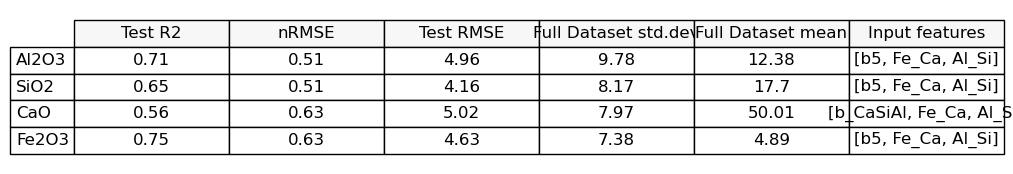

In [2591]:
# Create figure
fig, ax = plt.subplots(figsize=(12,2))  # Adjust size as needed
ax.axis('off')  # Hide axes

# Create table
table = plt.table(
    cellText=model_results_to_table.values,
    colLabels=model_results_to_table.columns,
    rowLabels=model_results_to_table.index,
    loc='center',
    cellLoc='center',
    colColours=['#f7f7f7']*len(model_results_to_table.columns)  # Light gray header
)

# Style adjustments
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.0, 1.6)  # Adjust cell padding

# Save as PNG
#plt.savefig('../Tables/model_results.png', 
 #           bbox_inches='tight', 
  #         dpi=300, 
   #         pad_inches=0.01)
plt.show()

In [1718]:
# Better test set generation
def generate_valid_test_set(X_test, y_test, n_samples:int):
    # Use bootstrapping instead of copying
    indices = np.random.choice(len(X_test), size=n_samples, replace=True)
    return X_test.iloc[indices], y_test.iloc[indices]

# Improved quantity generation
def generate_balanced_quantities(n_samples, target_sum=1e6):
    base_values = np.array([5000, 10000, 20000])
    avg = target_sum / n_samples
    
    quantities = []
    remaining_sum = target_sum
    
    for i in range(n_samples):
        if i == n_samples - 1:  # Last element must match remaining sum
            quantities.append(remaining_sum)
            break
            
        # Determine which base values are valid at this step
        valid = [v for v in base_values if v <= remaining_sum - (n_samples-i-1)*5000]
        if not valid:
            valid = [min(base_values)]  # Fallback to smallest value
            
        # Calculate weights only for valid values
        weights = 1 / np.abs(np.array(valid) - avg)
        weights = weights / weights.sum()  # Normalize to sum to 1
        
        # Randomly choose with adjusted weights
        q = np.random.choice(valid, p=weights)
        quantities.append(q)
        remaining_sum -= q
    
    return np.array(quantities)

In [2467]:
def evaluate_volume_estimation(model_selection, X_test_scaled, y_test, y_train ,n,fixed_quantity=10000):
    pred_differences = []
    stat_mean_differences = []
    summed_predictions = []
    summed_true = []
    average_error_pred = []
    average_error_base = []
    largest_error_pred = 0
    largest_error_base = 0
    
    scaled_y_train_mean = (y_train.mean()*n * fixed_quantity*10**-2).sum()
    scaled_y_train_std = (y_train.std()*n * fixed_quantity*10**-2).sum()
    #print(scaled_y_train_mean)    
    #print(scaled_y_train_std)
    count_pred_better_than_mean = 0
    
    for _ in range(10000):
        X_test_scaled_ext, y_test_ext = generate_valid_test_set(pd.DataFrame(X_test_scaled), y_test,n_samples=n)
        
        y_pred = model_selection.predict(X_test_scaled_ext)  # Shape (n_test_samples,)
        
        # 3. Optionally apply fixed quantity scaling
        scaled_y_pred = y_pred * fixed_quantity*10**-2
        scaled_y_true = y_test_ext * fixed_quantity*10**-2
        
        #scaled_y_train_min = pd.concat([y_train.mean()-y_train.std()]*n) * fixed_quantity*10**-2
        #scaled_y_train_max = pd.concat([y_train.mean()+y_train.std()]*n) * fixed_quantity*10**-2
        pred_differences.append(abs(scaled_y_true-scaled_y_pred))
        stat_mean_differences.append(abs(scaled_y_true-(pd.concat([y_train.mean()]*n)* fixed_quantity*10**-2)))

        pred_sum = float(scaled_y_pred.sum())
        true_sum = float(scaled_y_true.sum())
        
        largest_error_pred = max(largest_error_pred,float(1-(abs(pred_sum/true_sum)))*100)
        largest_error_base = max(largest_error_base,float(1-(abs(scaled_y_train_mean/true_sum)))*100)

        if abs(pred_sum-true_sum) < abs(scaled_y_train_mean-true_sum):
            # Prediction closer to true sum than stat mean
            count_pred_better_than_mean += 1
        
        summed_predictions.append(pred_sum)
        summed_true.append(true_sum)
        
        average_error_pred.append((1-(pred_sum/true_sum))*100)
        average_error_base.append((1-(scaled_y_train_mean/true_sum))*100)

    
    return (np.mean(summed_predictions).round(-1), # Pred quantity
    scaled_y_train_mean.round(-1), # Base case quantity
    np.mean(summed_true).round(-1), # True quantity
    np.std(summed_predictions).round(-1), # Pred std.dev quantity
    scaled_y_train_std.round(-1),  # Base case st.dev quantity
    np.std(summed_true).round(-1), # True std.dev quantity

    np.mean(average_error_pred).round(3), # Mean pred quantity error rate 
    np.mean(average_error_base).round(3), # Mean basecase quantity error rate 
    np.std(average_error_pred).round(3), # Std.dev pred quantity error rate 
    np.std(average_error_base).round(3), # Std.dev basecase quantity error rate 
            
    np.mean(pred_differences).round(-1), # Mean pred error per sample
    np.mean(stat_mean_differences).round(-1), # Mean base case error per sample
    np.std(pred_differences).round(-1), # Std. dev pred error per sample
    np.std(stat_mean_differences).round(-1),  # Std.dev basecase error per sample
    count_pred_better_than_mean)
            
    #round(largest_error_pred,2),
    #round(largest_error_base,2),
            
    
    


In [2715]:
test_evaluation10 = evaluate_volume_estimation(si_model,X_test_scaled,si_y_test,si_y_train,10)

In [2716]:
test_evaluation10 # Si

(np.float64(18410.0),
 np.float64(17850.0),
 np.float64(17100.0),
 np.float64(1900.0),
 np.float64(8440.0),
 np.float64(2190.0),
 np.float64(-8.262),
 np.float64(-6.195),
 np.float64(8.106),
 np.float64(14.486),
 np.float64(340.0),
 np.float64(560.0),
 np.float64(240.0),
 np.float64(430.0),
 5683)

In [2712]:
test_evaluation10 # Al

(np.float64(11660.0),
 np.float64(12340.0),
 np.float64(12520.0),
 np.float64(2430.0),
 np.float64(9930.0),
 np.float64(2890.0),
 np.float64(5.615),
 np.float64(-4.149),
 np.float64(12.315),
 np.float64(25.709),
 np.float64(420.0),
 np.float64(710.0),
 np.float64(270.0),
 np.float64(590.0),
 6711)

In [2468]:
al_evaluation5 = evaluate_volume_estimation(al_model,X_test_scaled,al_y_test,al_y_train,5)
al_evaluation10 = evaluate_volume_estimation(al_model,X_test_scaled,al_y_test,al_y_train,10)
al_evaluation50 = evaluate_volume_estimation(al_model,X_test_scaled,al_y_test,al_y_train,50)
al_evaluation100 = evaluate_volume_estimation(al_model,X_test_scaled,al_y_test,al_y_train,100)
#al_evaluation10

In [2469]:
si_evaluation5 = evaluate_volume_estimation(si_model,X_test_scaled,si_y_test,si_y_train,5)
si_evaluation10 = evaluate_volume_estimation(si_model,X_test_scaled,si_y_test,si_y_train,10)
si_evaluation50 = evaluate_volume_estimation(si_model,X_test_scaled,si_y_test,si_y_train,50)
si_evaluation100 = evaluate_volume_estimation(si_model,X_test_scaled,si_y_test,si_y_train,100)
#si_evaluation10

In [2470]:
ca_evaluation5 = evaluate_volume_estimation(ca_model,X_test_scaled,ca_y_test,ca_y_train,5)
ca_evaluation10 = evaluate_volume_estimation(ca_model,X_test_scaled,ca_y_test,ca_y_train,10)
ca_evaluation50 = evaluate_volume_estimation(ca_model,X_test_scaled,ca_y_test,ca_y_train,50)
ca_evaluation100 = evaluate_volume_estimation(ca_model,X_test_scaled,ca_y_test,ca_y_train,100)
#ca_evaluation10

In [2471]:
fe_evaluation5 = evaluate_volume_estimation(fe_model,X_test_scaled,fe_y_test,fe_y_train,5)
fe_evaluation10 = evaluate_volume_estimation(fe_model,X_test_scaled,fe_y_test,fe_y_train,10)
fe_evaluation50 = evaluate_volume_estimation(fe_model,X_test_scaled,fe_y_test,fe_y_train,50)
fe_evaluation100 = evaluate_volume_estimation(fe_model,X_test_scaled,fe_y_test,fe_y_train,100)
fe_evaluation10

(np.float64(5230.0),
 np.float64(4600.0),
 np.float64(6040.0),
 np.float64(2180.0),
 np.float64(6780.0),
 np.float64(2970.0),
 np.float64(7.442),
 np.float64(1.402),
 np.float64(23.919),
 np.float64(54.169),
 np.float64(300.0),
 np.float64(520.0),
 np.float64(360.0),
 np.float64(780.0),
 7501)

In [2428]:
fe_evaluation100

(np.float64(52070.0),
 np.float64(46000.0),
 np.float64(60210.0),
 np.float64(6660.0),
 np.float64(67760.0),
 np.float64(9180.0),
 np.float64(-15.525),
 np.float64(21.772),
 np.float64(8.342),
 np.float64(12.28),
 np.float64(300.0),
 np.float64(520.0),
 np.float64(360.0),
 np.float64(780.0),
 8421)

In [ ]:
return (np.mean(summed_predictions).round(-1), # Pred quantity
    scaled_y_train_mean.round(-1), # Base case quantity
    np.mean(summed_true).round(-1), # True quantity
    np.std(summed_predictions).round(-1), # Pred std.dev quantity
    scaled_y_train_std.round(-1),  # Base case st.dev quantity
    np.std(summed_true).round(-1), # True std.dev quantity

    np.mean(average_error_pred).round(3), # Mean pred quantity error rate 
    np.mean(average_error_base).round(3), # Mean basecase quantity error rate 
    np.std(average_error_pred).round(3), # Std.dev pred quantity error rate 
    np.std(average_error_base).round(3), # Std.dev basecase quantity error rate 
        
    np.mean(pred_differences).round(-1), # Mean pred error rate
    np.mean(stat_mean_differences).round(-1), # Mean base case error rate
    np.std(pred_differences).round(-1), # St.d dev pred error rate
    np.std(stat_mean_differences).round(-1)) # Std.dev basecase error rate
            
    #round(largest_error_pred,2),
    #round(largest_error_base,2),
            
    

In [2450]:
def create_table_evaluation(model_evaluation, elem_names):
    categories = ('Predicted', 'Base case','True')
    params = list(f"{elem} {category}" for elem in elem_names for category in categories)
    directory = {
    'Parameters':params,
    }
    df = pd.DataFrame(data=directory)

    # Extract std.dev errors from each model evaluation
    
    
    mean_quan_errors = [] # Quantity error   
    std_quan_errors = [] # quantity error
    mean_pred_errors = [] # Single value error
    std_pred_errors = []
    count_pred_closer_to_true = []
    
    for eval_data in model_evaluation:
        mean_quan_errors.extend(eval_data[6:8])  
        mean_quan_errors.append(0)  

        std_quan_errors.extend(eval_data[8:10])  # Slice [8:10] from each evaluation
        std_quan_errors.append(0)  # Add a separator zero (if needed)

        mean_pred_errors.extend(eval_data[10:12])  
        mean_pred_errors.append(0)  

        std_pred_errors.extend(eval_data[12:14])  # Slice [8:10] from each evaluation
        std_pred_errors.append(0)

        count_pred_closer_to_true.extend(eval_data[14:])
        count_pred_closer_to_true.append(np.nan)
        count_pred_closer_to_true.append(np.nan)
        
    
    
    df['Mean quantity'] = list(model_evaluation[0][0:3] + model_evaluation[1][0:3] + model_evaluation[2][0:3] + model_evaluation[3][0:3])
    #df['Std. dev summed quantity'] = list(model_evaluation[0][3:6] + model_evaluation[1][3:6] + model_evaluation[2][3:6] + model_evaluation[3][3:6])
    df['Mean quantity error rate %'] = mean_quan_errors
    df['Std.dev quantity error rate %'] = std_quan_errors
    df['Quantity error bars'] = df['Mean quantity'] * 2*df['Std.dev quantity error rate %'] *0.01 #(2*std.dev, 95% certain)
    df['Mean absolute error per sample'] = mean_pred_errors
    df['Std.dev absolute error per sample'] = std_pred_errors

    
    df.iloc[:,1:] = df.iloc[:,1:].apply(pd.to_numeric, errors='coerce')  # Convert strings to numbers if needed
    mae_decrease = []
    for i in range(0,len(df),3):
        if i+1 < len(df):
            divided = 1-(df.loc[i,'Mean absolute error per sample'] / df.loc[i+1,'Mean absolute error per sample'])*100
            mae_decrease.append(divided)
            mae_decrease.append(0)
            mae_decrease.append(0)
            
        else:
            break
            
    df['Error decrease per sample %'] = mae_decrease
    df['% num of predictions closer to true'] = [(i/10000)*100 for i in count_pred_closer_to_true]
    return df.round(2)
    
    

In [2472]:
table_eval5 = create_table_evaluation((al_evaluation5,si_evaluation5,ca_evaluation5,fe_evaluation5),('Al2O3','SiO2','CaO','Fe2O3'))
table_eval10 = create_table_evaluation((al_evaluation10,si_evaluation10,ca_evaluation10,fe_evaluation10),('Al2O3','SiO2','CaO','Fe2O3'))
table_eval50 = create_table_evaluation((al_evaluation50,si_evaluation50,ca_evaluation50,fe_evaluation50),('Al2O3','SiO2','CaO','Fe2O3'))
table_eval100 = create_table_evaluation((al_evaluation100,si_evaluation100,ca_evaluation100,fe_evaluation100),('Al2O3','SiO2','CaO','Fe2O3'))


In [2718]:
table_eval10

,Parameters,Mean quantity,Mean quantity error rate %,Std.dev quantity error rate %,Quantity error bars,Mean absolute error per sample,Std.dev absolute error per sample,Error decrease per sample %,% num of predictions closer to true
0,Al2O3 Predicted,11700.0,5.80,12.24,2863.93,420.0,270.0,-58.15,68.42
1,Al2O3 Base case,12340.0,-3.81,26.13,6448.14,710.0,590.0,0.00,NaN
2,Al2O3 True,12590.0,0.00,0.00,0.00,0.0,0.0,0.00,NaN
3,SiO2 Predicted,18460.0,-8.31,8.07,2980.55,340.0,240.0,-59.71,56.26
4,SiO2 Base case,17850.0,-5.98,14.44,5156.15,560.0,430.0,0.00,NaN
5,SiO2 True,17140.0,0.00,0.00,0.00,0.0,0.0,0.00,NaN
6,CaO Predicted,50580.0,-2.43,3.41,3449.56,380.0,370.0,-63.41,60.31
7,CaO Base case,50170.0,-1.74,5.02,5040.08,590.0,480.0,0.00,NaN
8,CaO True,49430.0,0.00,0.00,0.00,0.0,0.0,0.00,NaN
9,Fe2O3 Predicted,5230.0,7.44,23.92,2501.93,300.0,360.0,-56.69,75.01


In [2717]:
table_eval100

,Parameters,Mean quantity,Mean quantity error rate %,Std.dev quantity error rate %,Quantity error bars,Mean absolute error per sample,Std.dev absolute error per sample,Error decrease per sample %,% num of predictions closer to true
0,Al2O3 Predicted,116540.0,6.88,3.63,8467.80,420.0,270.0,-58.15,37.99
1,Al2O3 Base case,123390.0,1.00,7.30,18010.00,710.0,590.0,0.00,NaN
2,Al2O3 True,125310.0,0.00,0.00,0.00,0.0,0.0,0.00,NaN
3,SiO2 Predicted,184410.0,-7.84,2.47,9095.10,340.0,240.0,-59.71,17.78
4,SiO2 Base case,178520.0,-4.51,4.26,15224.19,560.0,430.0,0.00,NaN
5,SiO2 True,171100.0,0.00,0.00,0.00,0.0,0.0,0.00,NaN
6,CaO Predicted,505710.0,-2.37,1.07,10812.08,380.0,370.0,-63.41,29.64
7,CaO Base case,501670.0,-1.56,1.57,15772.50,590.0,480.0,0.00,NaN
8,CaO True,494070.0,0.00,0.00,0.00,0.0,0.0,0.00,NaN
9,Fe2O3 Predicted,52060.0,12.93,6.34,6596.00,300.0,360.0,-56.69,83.18


In [2612]:
table_eval100_no_true = table_eval100.iloc[[0,1,3,4,6,7,9,10],:]
table_eval10_no_true = table_eval10.iloc[[0,1,3,4,6,7,9,10],:]

In [2690]:
#table_eval100_no_true

In [2661]:
num_of_closer_predictions = pd.merge(table_eval100_no_true[['Parameters', '% num of predictions closer to true']],
                                    table_eval10_no_true[['Parameters', '% num of predictions closer to true']],
                                     how='inner',on='Parameters',suffixes=('_100','_10')
                                     ).dropna()

In [2603]:
table_eval100_no_true['Parameters']

0     Al2O3 Predicted
1     Al2O3 Base case
3      SiO2 Predicted
4      SiO2 Base case
6       CaO Predicted
7       CaO Base case
9     Fe2O3 Predicted
10    Fe2O3 Base case
Name: Parameters, dtype: object

In [2614]:
barchart100 = table_eval100_no_true[['Parameters','Mean quantity error rate %','Std.dev quantity error rate %']]
barchart10 = table_eval10_no_true[['Parameters','Mean quantity error rate %','Std.dev quantity error rate %']]

In [2706]:
# Manual color mapping
color_map = {
    'Al2O3 Predicted': '#1A4D8C',
    'Al2O3 Base case': '#7BA4D1',
    'SiO2 Predicted': '#C65A17',
    'SiO2 Base case': '#F0A77C',
    'CaO Predicted': '#7A0B1E',
    'CaO Base case': '#C87B85',
    'Fe2O3 Predicted': '#1E228B',
    'Fe2O3 Base case': '#7E81D3'
}
colors = [color_map[p] for p in table_eval100_no_true['Parameters']]

In [2812]:
barchart10 = barchart10.reset_index()
barchart100 = barchart100.reset_index()

In [2816]:
#
list_to_quantity_error10 = []
list_to_quantity_error100 = []
for i in range(0,len(barchart10)-1,2):
        if i == len(barchart10)-1:
            break
        else:
            list_to_quantity_error100.append((1-barchart100.loc[i,'Std.dev quantity error rate %']/barchart100.loc[i+1,'Std.dev quantity error rate %']).round(2))
            list_to_quantity_error100.append(0)
            list_to_quantity_error10.append((1-barchart10.loc[i,'Std.dev quantity error rate %']/barchart10.loc[i+1,'Std.dev quantity error rate %']).round(2))
            list_to_quantity_error10.append(0)
            
barchart10['Variance red. (%)'] = list_to_quantity_error10
barchart100['Variance red. (%)'] = list_to_quantity_error100


In [2819]:
barchart10

,index,Parameters,Mean quantity error rate %,Std.dev quantity error rate %,Variance red. (%)
0,0,Al2O3 Predicted,5.80,12.24,0.53
1,1,Al2O3 Base case,-3.81,26.13,0.00
2,3,SiO2 Predicted,-8.31,8.07,0.44
3,4,SiO2 Base case,-5.98,14.44,0.00
4,6,CaO Predicted,-2.43,3.41,0.32
5,7,CaO Base case,-1.74,5.02,0.00
6,9,Fe2O3 Predicted,7.44,23.92,0.56
7,10,Fe2O3 Base case,1.40,54.17,0.00


In [2820]:
barchart100

,index,Parameters,Mean quantity error rate %,Std.dev quantity error rate %,Variance red. (%)
0,0,Al2O3 Predicted,6.88,3.63,0.50
1,1,Al2O3 Base case,1.00,7.30,0.00
2,3,SiO2 Predicted,-7.84,2.47,0.42
3,4,SiO2 Base case,-4.51,4.26,0.00
4,6,CaO Predicted,-2.37,1.07,0.32
5,7,CaO Base case,-1.56,1.57,0.00
6,9,Fe2O3 Predicted,12.93,6.34,0.49
7,10,Fe2O3 Base case,21.67,12.40,0.00


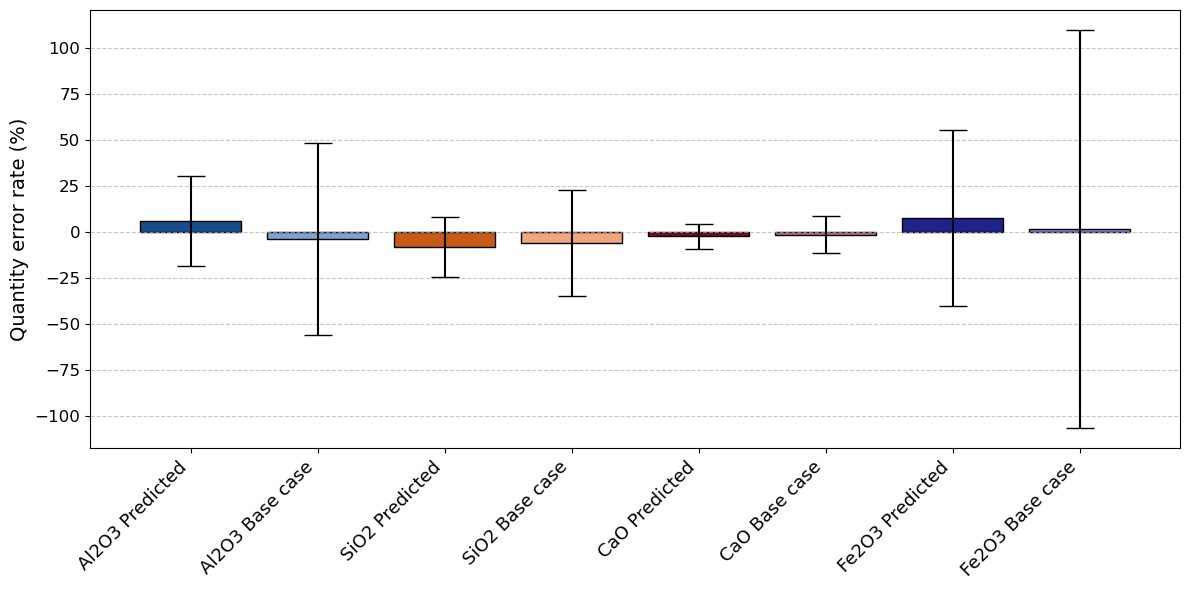

In [2806]:
plt.figure(figsize=(12, 6))
bars = plt.bar(
    x=barchart10['Parameters'],
    height=barchart10['Mean quantity error rate %'],
    yerr=2*barchart10['Std.dev quantity error rate %'],  # Error bars
    capsize=10,  # Caps on error bars
    color=colors,
    edgecolor='black'
)

# Customize the plot
#plt.title('Mean Quantity Estimates with Error Bars', fontsize=14)
#plt.xlabel('Parameters', fontsize=12)
plt.ylabel('Quantity error rate (%)', fontsize=14)
plt.xticks(rotation=45, ha='right',fontsize=13)  # Rotate x-axis labels
plt.yticks([i for i in range(-100,125,25)],fontsize=12)
#plt.yticks([i for i in range(-20,60,10)],fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
#legend_labels = {
#    'skyblue': 'Predicted',
#    'lightgreen': 'Base case',
#    'salmon': 'True'
#}
#patches = [plt.Rectangle((0,0),1,1, fc=color) for color in legend_labels.keys()]
#plt.legend(patches, legend_labels.values(), loc='upper right')

plt.tight_layout()  # Prevent label clipping
plt.savefig('../Figures/table_eval10.png',bbox_inches='tight')
plt.show()

In [2664]:
num_of_closer_predictions

,Parameters,% num of predictions closer to true_100,% num of predictions closer to true_10
0,Al2O3 Predicted,37.99,68.42
2,SiO2 Predicted,17.78,56.26
4,CaO Predicted,29.64,60.31
6,Fe2O3 Predicted,83.18,75.01


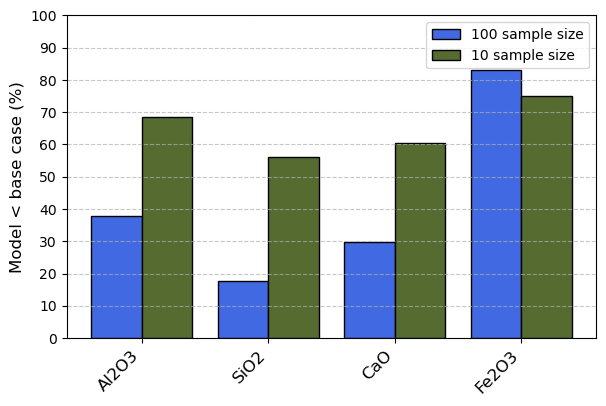

In [2822]:
plt.figure(figsize=(6, 4))

bar_width = 0.4
index = np.arange(len(num_of_closer_predictions['Parameters']))

bars1 = plt.bar(index - bar_width/2, num_of_closer_predictions['% num of predictions closer to true_100'], bar_width,
                color='royalblue', edgecolor='black', label='100 sample size')
bars2 = plt.bar(index + bar_width/2, num_of_closer_predictions['% num of predictions closer to true_10'], bar_width,
                color='darkolivegreen', edgecolor='black', label='10 sample size')

#plt.title('Amount of times (%) model predicts closer than base case', fontsize=14)
plt.ylabel('Model < base case (%)', fontsize=12)
plt.xticks(index, ['Al2O3','SiO2','CaO','Fe2O3'], rotation=45, ha='right', fontsize=12)
#num_of_closer_predictions['Parameters']
plt.yticks([i for i in range(0,110,10)],fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)
plt.legend()

plt.tight_layout(pad=0.5)
plt.savefig('../Figures/pred_closer_than_basecase.png',bbox_inches='tight')
plt.show()

In [2797]:
error_per_sample = table_eval100[['Parameters','Mean absolute error per sample','Std.dev absolute error per sample','Error decrease per sample %']]



In [2798]:
error_per_sample = error_per_sample.iloc[[0,1,3,4,6,7,9,10],:]

In [2799]:
error_per_sample.loc[:,['Mean absolute error per sample','Std.dev absolute error per sample']] = error_per_sample.loc[:,['Mean absolute error per sample','Std.dev absolute error per sample']]/100

In [2800]:
error_per_sample = error_per_sample.reset_index()
len(error_per_sample)

8

In [2801]:
#
list_to_variance_red = []
for i in range(0,len(error_per_sample)-1,2):
        if i == len(error_per_sample)-1:
            break
        else:
            list_to_variance_red.append((1-error_per_sample.loc[i,'Std.dev absolute error per sample']/error_per_sample.loc[i+1,'Std.dev absolute error per sample']).round(2))
            list_to_variance_red.append(0)
error_per_sample['Variance red. (%)'] = list_to_variance_red           

In [2802]:
#error_per_sample['Error decrease per sample %'] = error_per_sample['Error decrease per sample %']

In [2803]:
error_per_sample

,index,Parameters,Mean absolute error per sample,Std.dev absolute error per sample,Error decrease per sample %,Variance red. (%)
0,0,Al2O3 Predicted,4.2,2.7,-58.15,0.54
1,1,Al2O3 Base case,7.1,5.9,0.00,0.00
2,3,SiO2 Predicted,3.4,2.4,-59.71,0.44
3,4,SiO2 Base case,5.6,4.3,0.00,0.00
4,6,CaO Predicted,3.8,3.7,-63.41,0.23
5,7,CaO Base case,5.9,4.8,0.00,0.00
6,9,Fe2O3 Predicted,3.0,3.6,-56.69,0.54
7,10,Fe2O3 Base case,5.2,7.8,0.00,0.00


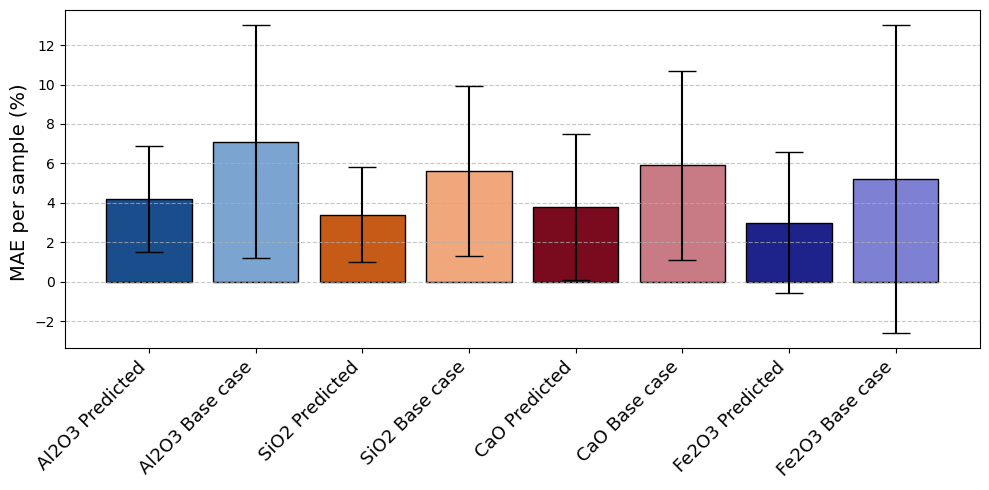

In [2804]:
plt.figure(figsize=(10, 5))

bar_width = 0.35
index = np.arange(len(error_per_sample['Parameters']))

bars1 = plt.bar(
                x = error_per_sample['Parameters'],
                height=error_per_sample['Mean absolute error per sample'],
                yerr=error_per_sample['Std.dev absolute error per sample'],  # Error bars
                capsize=10,  # Caps on error bars
                color=colors,
                edgecolor='black',
                )

#plt.title('Amount of times (%) model predicts closer than base case', fontsize=14)
plt.ylabel('MAE per sample (%) ', fontsize=14)
plt.xticks(index, error_per_sample['Parameters'], rotation=45, ha='right', fontsize=13)
#plt.yticks([i for i in range(0,110,10)],fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.ylim(0, 100)
#plt.legend()

plt.tight_layout()
#plt.savefig('../Figures/Sample_MAE.png',bbox_inches='tight')
plt.show()

In [2725]:
table_eval100

,Parameters,Mean quantity,Mean quantity error rate %,Std.dev quantity error rate %,Quantity error bars,Mean absolute error per sample,Std.dev absolute error per sample,Error decrease per sample %,% num of predictions closer to true
0,Al2O3 Predicted,116540.0,6.88,3.63,8467.80,420.0,270.0,-58.15,37.99
1,Al2O3 Base case,123390.0,1.00,7.30,18010.00,710.0,590.0,0.00,NaN
2,Al2O3 True,125310.0,0.00,0.00,0.00,0.0,0.0,0.00,NaN
3,SiO2 Predicted,184410.0,-7.84,2.47,9095.10,340.0,240.0,-59.71,17.78
4,SiO2 Base case,178520.0,-4.51,4.26,15224.19,560.0,430.0,0.00,NaN
5,SiO2 True,171100.0,0.00,0.00,0.00,0.0,0.0,0.00,NaN
6,CaO Predicted,505710.0,-2.37,1.07,10812.08,380.0,370.0,-63.41,29.64
7,CaO Base case,501670.0,-1.56,1.57,15772.50,590.0,480.0,0.00,NaN
8,CaO True,494070.0,0.00,0.00,0.00,0.0,0.0,0.00,NaN
9,Fe2O3 Predicted,52060.0,12.93,6.34,6596.00,300.0,360.0,-56.69,83.18


In [2736]:

color_map_incl_gray = {
    'Al2O3 Predicted': '#1A4D8C',
    'Al2O3 Base case': '#7BA4D1',
    'Al2O3 True': '#6A6969',
    'SiO2 Predicted': '#C65A17',
    'SiO2 Base case': '#F0A77C',
    'SiO2 True': '#6A6969',
    'CaO Predicted': '#7A0B1E',
    'CaO Base case': '#C87B85',
    'CaO True': '#6A6969',
    'Fe2O3 Predicted': '#1E228B',
    'Fe2O3 Base case': '#7E81D3',
    'Fe2O3 True': '#6A6969'
}
colors_incl_gray = [color_map_incl_gray[p] for p in table_eval100['Parameters']]


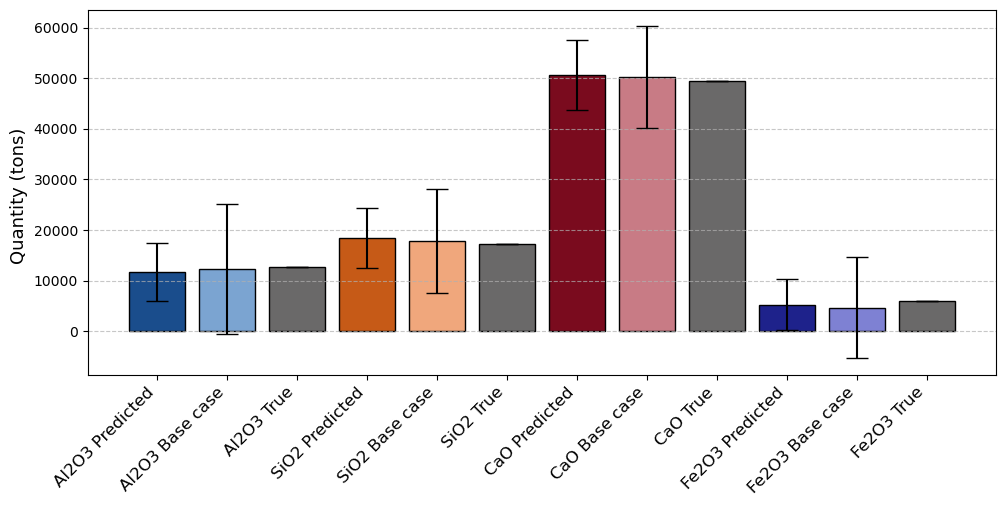

In [2763]:
plt.figure(figsize=(10, 5))


index = np.arange(len(table_eval10['Parameters']))

bars1 = plt.bar(
                x = table_eval10['Parameters'],
                height=table_eval10['Mean quantity'],
                yerr=2*table_eval10['Quantity error bars'],  # Error bars
                capsize=8,  # Caps on error bars
                color=colors_incl_gray,
                edgecolor='black',
                width = 0.8
                )

#plt.title('Amount of times (%) model predicts closer than base case', fontsize=14)
plt.ylabel('Quantity (tons) ', fontsize=13)
plt.xticks(index, table_eval100['Parameters'], rotation=45, ha='right', fontsize=12)
#plt.yticks([i for i in range(0,550000,50000)],fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.ylim(0, 100)
#plt.legend()

plt.tight_layout(pad=0.5)
plt.savefig('../Figures/total_quantity_10.png',bbox_inches='tight')
plt.show()

In [1993]:

y_pred = al_model.predict(X_test_scaled)  # Shape (n_test_samples,)


scaled_y_pred = y_pred * fixed_quantity*10**-2
scaled_y_pred_std = y_pred.std() * fixed_quantity*10**-2
scaled_y_true = y_test * fixed_quantity*10**-2
scaled_y_true_std = y_test.std() * fixed_quantity*10**-2
y_train_mean = y_train.mean()*23* fixed_quantity*10**-2
y_train_std = y_train.std()*23* fixed_quantity*10**-2

#scaled_y_train_min = pd.concat([y_train.mean()-y_train.std()]*n) * fixed_quantity*10**-2
#scaled_y_train_max = pd.concat([y_train.mean()+y_train.std()]*n) * fixed_quantity*10**-2
#pred_differences.append(abs(scaled_y_true-scaled_y_pred))
#stat_mean_differences.append(abs(scaled_y_true-(pd.concat([y_train.mean()]*n)* fixed_quantity*10**-2)))

#summed_predictions.append(scaled_y_pred.sum())
#summed_true.append(scaled_y_true.sum())

np.float64(780.2587048483664)

In [2001]:
print(scaled_y_pred.sum().round(-1))
print(y_train_mean.sum().round(-1))
print(scaled_y_true.sum()[0].round(-1))
print()
print(scaled_y_pred_std.round(-1))
print(y_train_std[0].round(-1))
print(scaled_y_true_std[0].round(-1))


26810.0
28380.0
28830.0

780.0
22840.0
940.0


In [1780]:
 
# First need to align dimensions by taking diagonal elements
baseline_diags = np.array([np.diag(mean_diffs[i]) for i in range(100)])
model_means = pred_diffs.mean(axis=1)              # Shape (100,)
baseline_means = baseline_diags.mean(axis=1)       # Shape (100,)

# Perform paired t-test
t_stat, p_val = ttest_rel(baseline_means, model_means)

print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_val:.4f}")

if p_val < 0.05:
    print("✅ Significant difference between model and baseline")
else:
    print("⚠️ No significant difference")

t-statistic: 71.169
p-value: 0.0000
✅ Significant difference between model and baseline


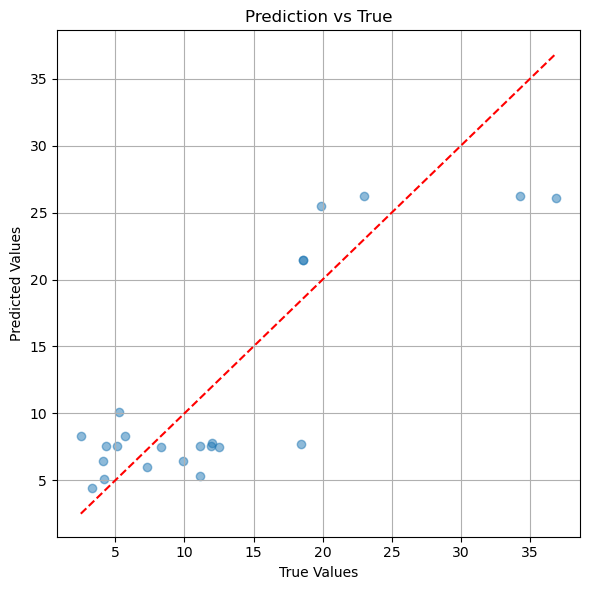

In [1678]:
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs True")
plt.grid(True)
plt.tight_layout()
plt.show()

In [318]:
df.describe()

,Index,CaO,SiO2,Al2O3,Fe2O3,MgO,MnO,P2O5,TiO2,CaF2,f-CaO,others,FeO,S,Fe,Na2O,K2O,Cl-,SO4 2-,Mo,Zn,Ni,Cu,K,Ti,V,SO3,CO2,LOI,·others MnO + TiO2 + SO3 + Na2O + K2O,f-CaO + CaOH2,f-MgO,C,reactive SiO2,Na2Oeq,Mn2O3,ZnO,K2O + Na2O,Femet,PbO,CuO,BaO,SeO2,B2O3,FeOtotal,F,Cl,P,Sr,Ba,Pb,Sc2O3,Fe_tot,Cr,Cr2O3,Sum,Fe_Ca,Al_Si,Al_Si_kmeans
count,113.00000,113.000000,113.000000,113.000000,112.000000,112.000000,64.000000,23.000000,44.000000,1.00,14.00000,24.000000,30.000000,36.000000,4.000000,24.000000,27.000000,1.00,2.000000,1.00,2.000000,1.000,2.000000,1.000,2.000000,1.000,33.000000,5.000000,34.000000,1.0,1.0,6.000000,9.000000,2.000000,1.00,2.000000,5.000000,1.0,6.00000,3.00,2.00,3.000000,1.0000,1.0,1.00,7.000000,4.000000,1.000000,1.000000,1.0000,1.0000,1.0,13.000000,2.000000,19.000000,113.000000,113.000000,113.000000,113.000000
mean,57.00000,50.008841,17.704991,12.378230,4.920795,8.333420,0.817391,0.221304,0.608273,1.57,5.03550,2.935571,4.995667,0.661371,1.687500,0.358583,0.111333,0.03,0.230000,0.28,0.033150,0.007,0.010000,0.008,0.044087,0.028,1.618727,2.118000,6.875588,4.0,12.0,8.166667,0.346667,20.450000,0.39,6.963500,0.854000,0.1,0.55000,0.06,0.02,0.213333,0.3837,0.1,1.74,1.844286,0.068065,0.000431,0.000305,0.0292,0.0072,10.5,1.606923,0.136413,0.502316,101.246783,-0.097345,0.530973,0.681416
std,32.76431,7.974618,8.170216,9.784217,7.410270,4.073251,0.801893,0.562939,0.503490,NaN,5.88252,2.027038,6.368572,0.421455,1.061552,0.442292,0.203978,NaN,0.028284,NaN,0.005445,NaN,0.011314,NaN,0.056446,NaN,1.082896,3.101551,5.480884,NaN,NaN,3.710346,0.458094,0.070711,NaN,1.607254,0.526146,NaN,0.13784,0.00,0.00,0.023094,NaN,NaN,NaN,0.950559,0.067265,NaN,NaN,NaN,NaN,NaN,1.185941,0.188921,0.943195,8.464624,0.297748,0.655619,0.468003
min,1.00000,24.899000,0.730000,0.000000,0.270000,2.130000,0.050000,0.001000,0.100000,1.57,0.00000,0.383700,0.500000,0.010000,0.400000,0.020000,0.010000,0.03,0.210000,0.28,0.029300,0.007,0.002000,0.008,0.004174,0.028,0.120000,0.200000,-1.300000,4.0,12.0,3.000000,0.040000,20.400000,0.39,5.827000,0.040000,0.1,0.40000,0.06,0.02,0.200000,0.3837,0.1,1.74,0.590000,0.002261,0.000431,0.000305,0.0292,0.0072,10.5,0.190000,0.002825,0.010000,83.562000,-1.000000,-1.000000,0.000000
25%,29.00000,45.900000,11.800000,4.300000,1.147500,5.445000,0.286750,0.030000,0.322500,1.57,0.35375,1.572500,1.020000,0.330000,1.352500,0.065000,0.017500,0.03,0.220000,0.28,0.031225,0.007,0.006000,0.008,0.024131,0.028,0.890000,0.300000,3.012500,4.0,12.0,6.500000,0.120000,20.425000,0.39,6.395250,0.600000,0.1,0.50000,0.06,0.02,0.200000,0.3837,0.1,1.74,1.390000,0.030565,0.000431,0.000305,0.0292,0.0072,10.5,0.700000,0.069619,0.040000,98.470000,0.000000,0.000000,0.000000
50%,57.00000,51.000000,17.700000,9.220000,2.375000,7.350000,0.525000,0.050000,0.463000,1.57,2.54500,2.390000,1.880000,0.596500,1.675000,0.114000,0.050000,0.03,0.230000,0.28,0.033150,0.007,0.010000,0.008,0.044087,0.028,1.600000,1.100000,5.450000,4.0,12.0,8.000000,0.200000,20.450000,0.39,6.963500,1.210000,0.1,0.50000,0.06,0.02,0.200000,0.3837,0.1,1.74,1.760000,0.055000,0.000431,0.000305,0.0292,0.0072,10.5,1.600000,0.136413,0.080000,100.000000,0.000000,1.000000,1.000000
75%,85.00000,55.400000,22.680000,18.640000,4.787500,10.925000,1.152500,0.150000,0.795000,1.57,8.92500,4.355000,4.875000,0.902750,2.010000,0.630000,0.095000,0.03,0.240000,0.28,0.035075,0.007,0.014000,0.008,0.064044,0.028,1.930000,1.400000,9.950000,4.0,12.0,9.500000,0.350000,20.475000,0.39,7.531750,1.210000,0.1,0.57500,0.06,0.02,0.220000,0.3837,0.1,1.74,2.065000,0.092500,0.000431,0.000305,0.0292,0.0072,10.5,2.200000,0.203206,0.600000,101.920000,0.000000,1.000000,1.000000
max,113.00000,68.270000,50.100000,36.910000,37.600000,21.500000,4.000000,2.730000,2.510000,1.57,19.00000,8.700000,21.800000,1.630000,3.000000,1.600000,1.000000,0.03,0.250000,0.28,0.037000,0.007,0.018000,0.008,0.084000,0.028,5.570000,7.590000,26.200000,4.0,12.0,14.000000,1.520000,20.500000,0.39,8.100000,1.210000,0.1,0.80000,0.06,0.02,0.240000,0.3837,0.1,1.74,3.650000,0.1

In [1188]:
import statsmodels.api as sm

#X = test[['b5','SiO2_mean','CaO_mean']] # 
#X = test[['b5','Al2O3_mean','CaO_mean']] # ,'CaO_mean'
X = test[['b_CaSiAl','Fe_Ca','Al_Si_kmeans']]
y = test['CaO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = sm.add_constant(X_train_scaled)

model = sm.OLS(y_train, X_train_scaled)
results = model.fit()

X_test_scaled = sm.add_constant(X_test_scaled, has_constant='add')  # Ensures alignment with training

y_pred = results.predict(X_test_scaled)

# Compare predictions to true values
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² on test:", r2_score(y_test, y_pred))

Test RMSE: 4.4703484686694095
R² on test: 0.6532186790306805


In [1189]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CaO   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     40.70
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           1.81e-16
Time:                        12:51:46   Log-Likelihood:                -275.29
No. Observations:                  90   AIC:                             558.6
Df Residuals:                      86   BIC:                             568.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.1644      0.556     90.252      0.000      49.059      51.269
x1             5.3250      0.584      9.121      0.000       4.164       6.486
x2             2.9177      0.560      5.213      0.000       1.805       4.030
x3            -1.8140      0.583     -3.113      0.003      -2.972      -0.656
==============================================================================
Omnibus:                       19.341   Durbin-Watson:                   2.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.319
Skew:                          -0.886   Prob(JB):                     1.58e-07
Kurtosis:                       5.284   Cond. No.                         1.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""